# Analisis Asuransi Perjalanan: Klaim Asuransi untuk Perlindungan

## Pemahaman Masalah Bisnis

**Context**

Asuransi perjalanan adalah perlindungan penting saat kita bepergian, baik di dalam negeri maupun ke luar negeri. Beberapa negara, seperti di Eropa dan Amerika, bahkan mewajibkan wisatawan memiliki asuransi perjalanan. Premi asuransi ini bervariasi tergantung pada cakupan yang dipilih, durasi, dan tujuan perjalanan.

Sebuah perusahaan asuransi perjalanan kini berupaya memahami pemegang polis mana yang kemungkinan besar akan mengajukan klaim. Informasi ini sangat penting untuk meningkatkan efisiensi, mengurangi beban kerja, dan memperbaiki kualitas layanan kepada pelanggan.

Tujuan analisis ini adalah:

No (0) : Pemilik Asuransi tidak mengajukan claim

Yes (1) : Pemilik Asuransi mengajukan claim

Dengan informasi ini, perusahaan dapat memberikan pelayanan yang lebih baik dan responsif kepada para pelaku perjalanan.

**Problem Statement**

Strategi pemasaran saat ini kurang efisien karena tidak membedakan pelanggan, yang menyebabkan pemborosan sumber daya dan hilangnya peluang untuk berinteraksi dengan calon pelanggan. Perusahaan ingin mengatasi ini dengan lebih efektif membedakan dan menargetkan calon pelanggan yang kemungkinan besar akan melakukan klaim. Langkah ini akan mengoptimalkan penggunaan sumber daya dan meningkatkan kepuasan pelanggan potensial.

**Goals**

Menghadapi tantangan ini, perusahaan berencana menerapkan model prediktif untuk mengelompokkan pelanggan berdasarkan kemungkinan klaim mereka diterima. Dengan cara ini, perusahaan dapat menghemat waktu dan biaya pemasaran yang berharga.

Selain itu, perusahaan ingin mengidentifikasi faktor-faktor yang mempengaruhi persetujuan klaim. Pengetahuan ini akan digunakan untuk memperbaiki proses pengambilan keputusan dan meningkatkan layanan pelanggan secara keseluruhan.

**Analytics Approach**

Langkah pertama adalah menganalisis data historis untuk mengungkap tren dan pola yang membedakan antara klaim yang disetujui dan yang ditolak. Dengan pemahaman ini, kita akan membangun model klasifikasi yang canggih untuk membantu perusahaan memprediksi klaim mana yang akan diterima dan mana yang akan ditolak. Model ini akan menjadi kunci dalam mengoptimalkan efisiensi dan akurasi pengelolaan klaim asuransi.

**Metric Evaluation**

![image.png](attachment:image.png)

- True Positive: Calon pelaku perjalanan melakukan Claim dan diprediksi model melakukan Claim
- False Positive: Calon pelaku perjalanan tidak melakukan Claim, namun diprediksi model melakukan Claim
- False Negative: Calon pelaku perjalanan melakukan Claim, namun diprediksi model tidak melakukan Claim
- True Negative: Calon pelaku perjalanan tidak melakukan Claim dan diprediksi model tidak melakukan Claim

Error type 1 (False Positive):
Konsekuensi: Biaya pemasaran dan sumber daya perusahaan terbuang percuma.

Error type 2 (False Negative):
Konsekuensi: Kehilangan calon potensial.

Berdasarkan konsekuensi dari setiap jenis kesalahan, fokus utama dari model yang akan kita buat adalah meminimalkan Error type 2 karena konsekuensi dari False Negative lebih serius daripada False Positives (Type I error). Error tipe 2 ini jenis kesalahan ini berpotensi menurunkan pendapatan perusahaan yang diakibatkan dari kehilangan calon pelanggan potensial. Jadi nanti metric utama yang akan kita gunakan adalah recall score.


## Data Understanding

### Attributes Informartion

| Attribute | Data Type, Length | Description |
| --- | --- | --- |
| Agency | object | Name of agency |
| Agency Type | object | Type of travel insurance agencies |
| Distribution Channel | object | Channel of travel insurance agencies |
| Product Name | object | Name of the travel insurance products |
| Gender | object | Gender of insured |
| Duration | Int | Duration of travel |
| Destination | object | Destination of travel |
| Net Sales | Float | Amount of sales of travel insurance policies |
| Commission (in value) | Float | Commission received for travel insurance agency |
| Age | Int | Age of insured |
| Claim | Text | No – Claim status is rejected, Yes – Claim status is accepted |

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import missingno

from scipy.stats import yeojohnson, probplot

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, RobustScaler, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from sklearn.preprocessing import PolynomialFeatures

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Imbalance Dataset
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

In [80]:
df = pd.read_csv('data_travel_insurance.csv')
df

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.00,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.00,33,No
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.70,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.00,59,No
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.00,28,No
...,...,...,...,...,...,...,...,...,...,...,...
44323,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,14,CHINA,30.0,0.00,36,Yes
44324,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,NaN,17,AUSTRALIA,79.2,47.52,47,No
44325,TST,Travel Agency,Offline,Travel Cruise Protect,M,64,THAILAND,30.0,10.50,50,No
44326,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,51,CHINA,36.0,0.00,36,No


In [81]:
# Cek info lebih detail untuk setiap fitur
listItem = []

for col in df.columns:
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col]))*100, 2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)])

pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,Agency,object,0,0.00,16,"[KML, EPX]"
1,Agency Type,object,0,0.00,2,"[Travel Agency, Airlines]"
2,Distribution Channel,object,0,0.00,2,"[Online, Offline]"
3,Product Name,object,0,0.00,26,"[2 way Comprehensive Plan, Gold Plan]"
4,Gender,object,31647,71.39,2,"[M, nan]"
5,Duration,int64,0,0.00,437,"[193, 249]"
6,Destination,object,0,0.00,138,"[LITHUANIA, ISRAEL]"
7,Net Sales,float64,0,0.00,1006,"[0.81, 6.71]"
8,Commision (in value),float64,0,0.00,915,"[1.66, 11.54]"
9,Age,int64,0,0.00,89,"[56, 118]"


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44328 entries, 0 to 44327
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                44328 non-null  object 
 1   Agency Type           44328 non-null  object 
 2   Distribution Channel  44328 non-null  object 
 3   Product Name          44328 non-null  object 
 4   Gender                12681 non-null  object 
 5   Duration              44328 non-null  int64  
 6   Destination           44328 non-null  object 
 7   Net Sales             44328 non-null  float64
 8   Commision (in value)  44328 non-null  float64
 9   Age                   44328 non-null  int64  
 10  Claim                 44328 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 3.7+ MB


Berdasarkan analisis awal fitur-fitur dalam dataset:

1. Tidak ada nilai yang hilang untuk sebagian besar fitur, kecuali kolom Gender yang memiliki sekitar 71.39% nilai yang hilang.
1. Ada beberapa fitur kategorikal seperti Agency, Agency Type, Distribution Channel, Product Name, Gender, Destination dan Claim.
1. Fitur-fitur numerik mencakup Duration, Net Sales, Commision (in value), dan Age.

In [83]:
display(df.describe(include='number'))
display(df.describe(include='object'))

,Duration,Net Sales,Commision (in value),Age
count,44328.000000,44328.000000,44328.000000,44328.000000
mean,49.424292,40.550948,9.707692,39.925600
std,109.153961,48.661970,19.625637,13.954926
min,-1.000000,-357.500000,0.000000,0.000000
25%,9.000000,18.000000,0.000000,35.000000
50%,22.000000,26.500000,0.000000,36.000000
75%,53.000000,48.000000,11.550000,43.000000
max,4881.000000,810.000000,283.500000,118.000000


,Agency,Agency Type,Distribution Channel,Product Name,Gender,Destination,Claim
count,44328,44328,44328,44328,12681,44328,44328
unique,16,2,2,26,2,138,2
top,EPX,Travel Agency,Online,Cancellation Plan,M,SINGAPORE,No
freq,24656,32113,43572,12979,6504,9267,43651


Berikut adalah ringkasan statistik untuk fitur numerik dan kategorikal:

1. Fitur Numerik:
    1. Duration: Waktu asuransi berlangsung. Ada durasi dengan nilai negatif yang mungkin perlu diperbaiki.
    1. Net Sales: Nilai penjualan bersih. Ada nilai negatif yang mungkin memerlukan investigasi lebih lanjut.
    1. Commision (in value): Komisi yang diterima. Sebagian besar entri memiliki komisi nol.
    1. Age: Usia klien. Ada entri dengan usia 0 dan 118 dengan median 36. usia 118 mungkin perlu diverifikasi.

1. Fitur Kategorikal:
    1. Agency: Ada 16 agency unik, dengan agen EPX sebagai agen yang paling sering muncul.
    1. Agency Type: Ada 2 tipe agency, dengan "Travel Agency" sebagai tipe yang paling dominan.
    1. Distribution Channel: Sebagian besar asuransi dijual secara online.
    1. Product Name: Ada 26 produk asuransi unik, dengan "Cancellation Plan" sebagai produk yang paling sering muncul.
    1. Gender: Hanya sekitar 28.61% entri yang memiliki informasi gender, dengan jenis kelamin M (pria) sedikit lebih dominan.
    1. Destination: Ada 138 tujuan unik, dengan Singapura sebagai tujuan yang paling sering muncul.
    1. Claim: Ada 2 unik value, dengan "No" sebagai value yang paling dominan.

### Numerik

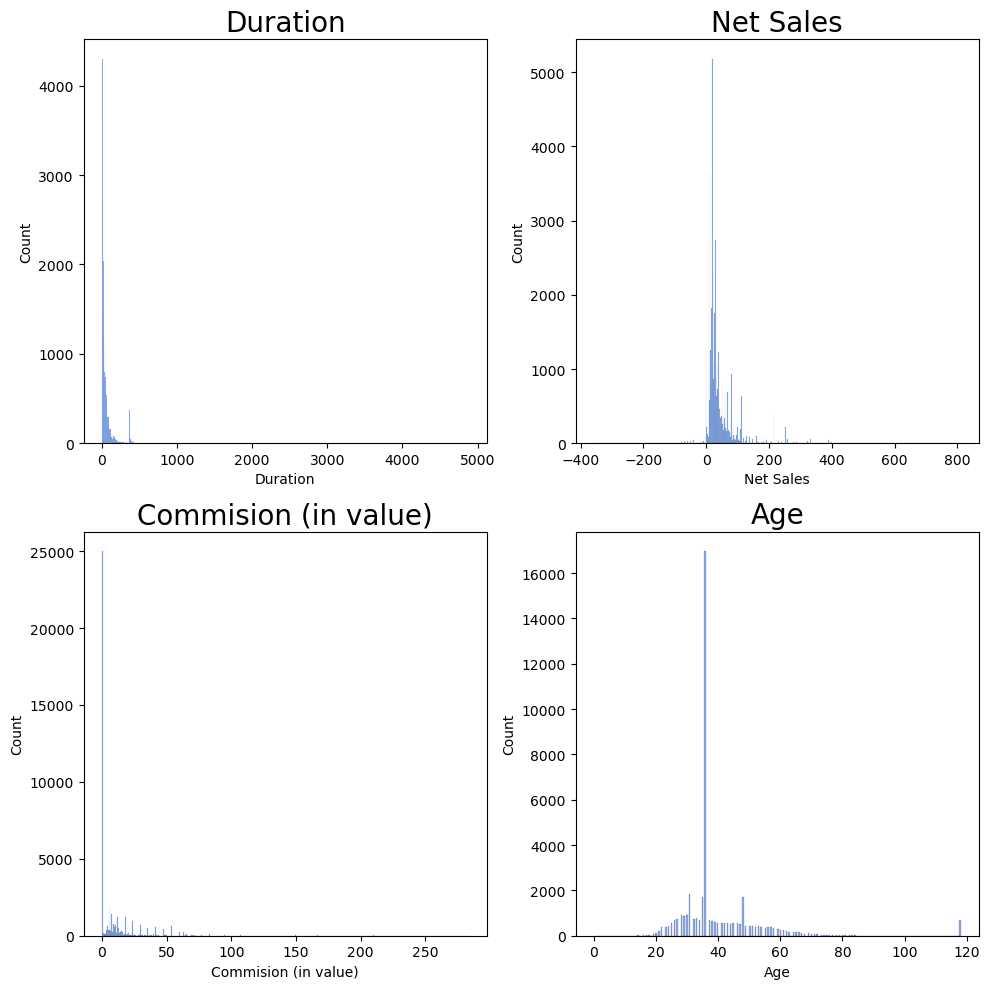

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(10, 10))

# Inisialisasi nomor plot
plotnumber = 1

# Mengambil fitur-fitur numerik dari dataframe
num_features = df.select_dtypes(include='number').columns

# Iterasi melalui setiap fitur numerik
for feature in num_features:
    # Membuat subplot dengan 2 baris dan 2 kolom, dan nomor subplot yang ditentukan
    ax = plt.subplot(2, 2, plotnumber)
    
    # Membuat histogram untuk setiap fitur numerik
    sns.histplot(data=df, x=feature, color='cornflowerblue')
    
    # Menambahkan judul subplot
    plt.title(feature, fontsize=20)
    
    # Menambahkan nomor subplot
    plotnumber += 1
    
    # Menata layout plot
    plt.tight_layout()
    
# Menampilkan plot
plt.show()


Visualisasi Distribusi dengan Histogram:

1. Duration: Sebagian besar data berkonsentrasi di sekitar angka rendah, tetapi ada beberapa data yang memiliki durasi yang sangat tinggi. Ini menunjukkan adanya kemungkinan outlier.
1. Net Sales: Distribusi tampaknya mendekati normal tetapi memiliki beberapa outlier di bagian kanan.
1. Commision (in value): Kebanyakan data berada di angka rendah dengan beberapa nilai yang lebih tinggi, menunjukkan kemungkinan outlier.
1. Age: Kebanyakan data berkonsentrasi di sekitar usia 30-50, tetapi ada beberapa data di atas usia 100, yang mungkin perlu diverifikasi lebih lanjut.
1. Claim: untuk claim karena hanya binary jadi distribusi data hanya di 0 dan 1.

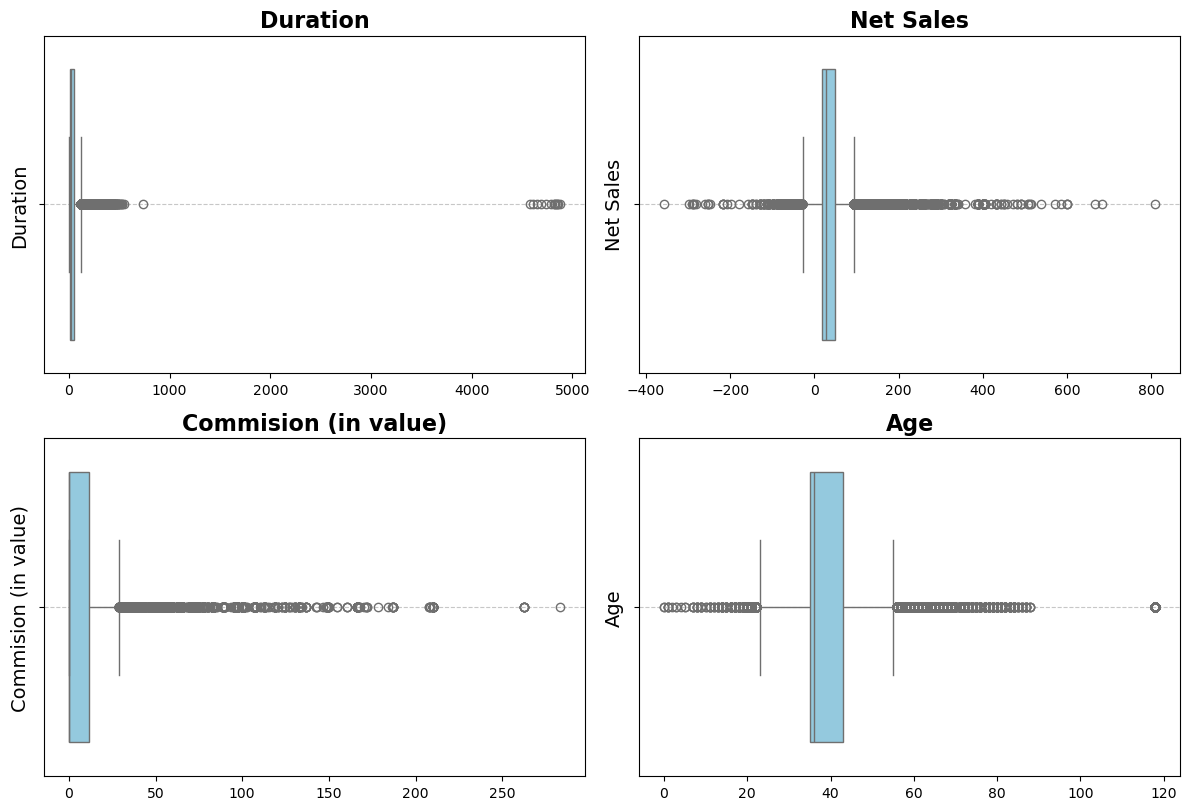

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

# Membuat gambar dengan ukuran 12x12
plt.figure(figsize=(12, 12))

# Inisialisasi nomor plot
plotnumber = 1

# Mengambil fitur-fitur numerik dari dataframe
num_features = df.select_dtypes(include='number').columns

# Iterasi melalui setiap fitur numerik
for feature in num_features:
    # Membuat subplot dengan 3 baris dan 2 kolom, dan nomor subplot yang ditentukan
    ax = plt.subplot(3, 2, plotnumber)
    
    # Membuat boxplot untuk setiap fitur numerik dengan palet warna yang menarik
    sns.boxplot(data=df, x=feature, color='skyblue')
    
    # Menambahkan judul subplot
    plt.title(feature, fontsize=16, weight='bold', color='black')
    
    # Menambahkan label sumbu x
    plt.xlabel('')
    
    # Menambahkan label sumbu y
    plt.ylabel(feature, fontsize=14, color='black')
    
    # Menambahkan garis grid horizontal
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Menambahkan nomor subplot
    plotnumber += 1
    
    # Menata layout plot
    plt.tight_layout()
    
# Menampilkan plot
plt.show()


Visualisasi Outliers dengan Boxplot:

1. Duration: Ada banyak outlier di atas, yang menunjukkan beberapa transaksi dengan durasi yang sangat panjang.
1. Net Sales: Ada beberapa outlier pada kolom net sales.
1. Commision (in value): Beberapa outlier di bagian atas menunjukkan komisi yang tinggi untuk beberapa transaksi.
1. Age: Seperti yang disebutkan sebelumnya, ada beberapa data untuk usia di atas 100 yang mungkin perlu diverifikasi.
1. Claim: untuk claim karena hanya binary jadi distribusi data hanya di 0 dan 1.

jelaskan outliers

In [86]:
# Memilih kolom-kolom dengan tipe data numerik (tidak termasuk objek)
df_numerik = df.select_dtypes(exclude='object')

# Menampilkan DataFrame yang hanya berisi kolom-kolom numerik
df_numerik


,Duration,Net Sales,Commision (in value),Age
0,365,216.0,54.00,57
1,4,10.0,0.00,33
2,19,22.0,7.70,26
3,20,112.0,0.00,59
4,8,16.0,4.00,28
...,...,...,...,...
44323,14,30.0,0.00,36
44324,17,79.2,47.52,47
44325,64,30.0,10.50,50
44326,51,36.0,0.00,36


#### Korelasi Data

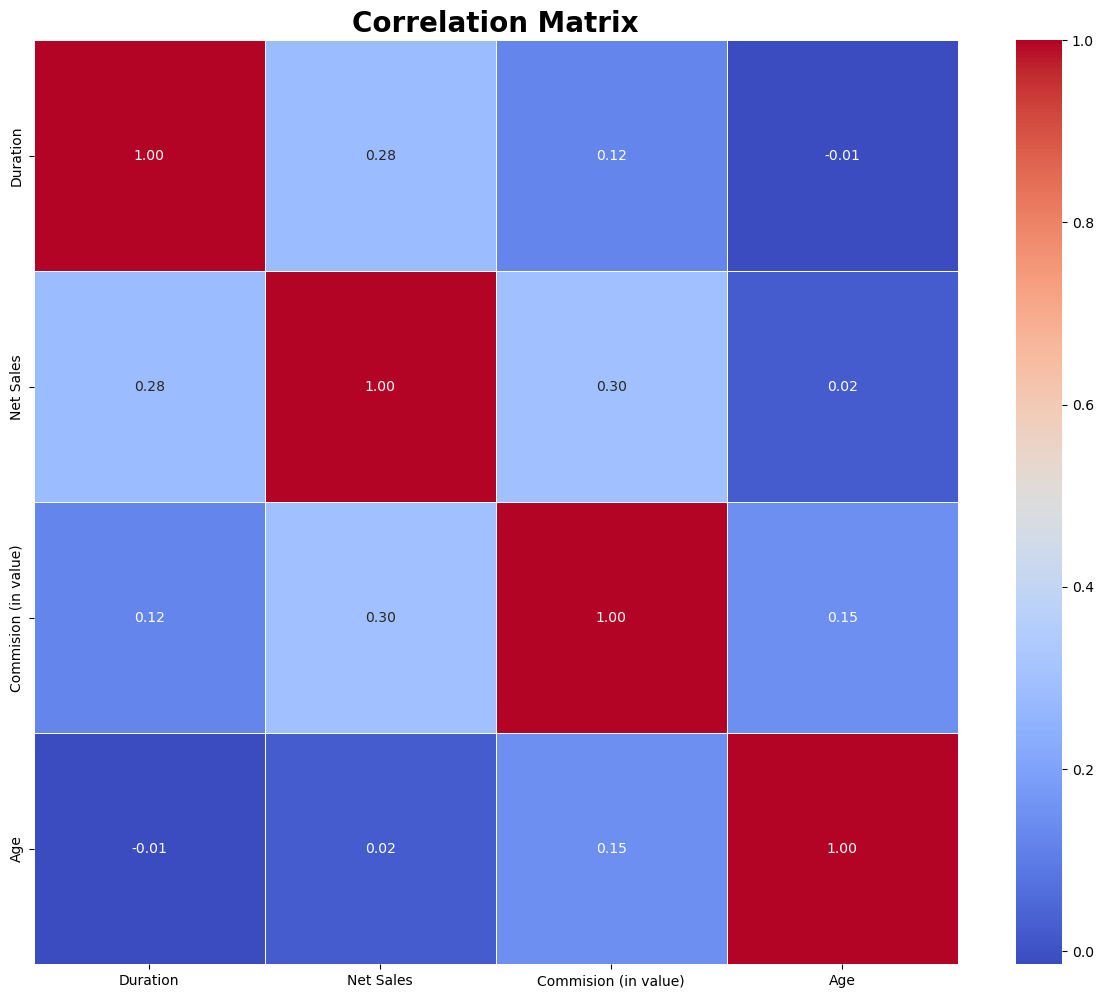

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

# Membuat gambar dengan ukuran 15x12
plt.figure(figsize=(15, 12))

# Menggunakan palet warna yang lebih menarik untuk heatmap
palette = sns.color_palette("coolwarm", as_cmap=True)

# Menghitung korelasi antar fitur menggunakan metode korelasi Spearman
corr = df_numerik.corr(method='spearman')

# Membuat heatmap korelasi dengan anotasi dan format desimal dua angka di dalam sel
sns.heatmap(corr, annot=True, fmt='.2f', cmap=palette, square=True, linewidths=.5)

# Menambahkan judul pada heatmap
plt.title('Correlation Matrix', size=20, weight='bold', color='black')

# Menampilkan heatmap
plt.show()


Secara garis besar:  
* kolom `Net Sales` memiliki korelasi yang cukup tinggi terhadap kolom `Commision (in value)`.

#### Multicollinearity

In [88]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

# Import library yang dibutuhkan
import pandas as pd

# DataFrame df_numerik telah didefinisikan sebelumnya

# Menghitung VIF untuk setiap variabel
vif_data = pd.DataFrame()
vif_data['Feature'] = df_numerik.columns
vif_data['VIF'] = [variance_inflation_factor(df_numerik.values, i) for i in range(len(df_numerik.columns))]

# Menampilkan data VIF
vif_data


,Feature,VIF
0,Duration,1.430126
1,Net Sales,2.965873
2,Commision (in value),2.153032
3,Age,1.619282


Berdasarkan perhitungan Variance Inflation Factor (VIF):

Duration: VIF sekitar 1.09, yang jauh di bawah ambang batas umum 5 atau 10, menunjukkan tidak ada multikolinearitas.
Net Sales: VIF sekitar 1.14, juga menunjukkan tidak ada multikolinearitas.
Commision: VIF sekitar 1.12, menunjukkan tidak ada multikolinearitas.
Age: VIF sekitar 1.05, menunjukkan tidak ada multikolinearitas.
VIF untuk semua variabel independen di bawah ambang batas umum (5 atau 10), yang menunjukkan bahwa tidak ada multikolinearitas yang serius di antara variabel ini.

### Kategorik

In [89]:
df_katogerik = df.select_dtypes(include='object')

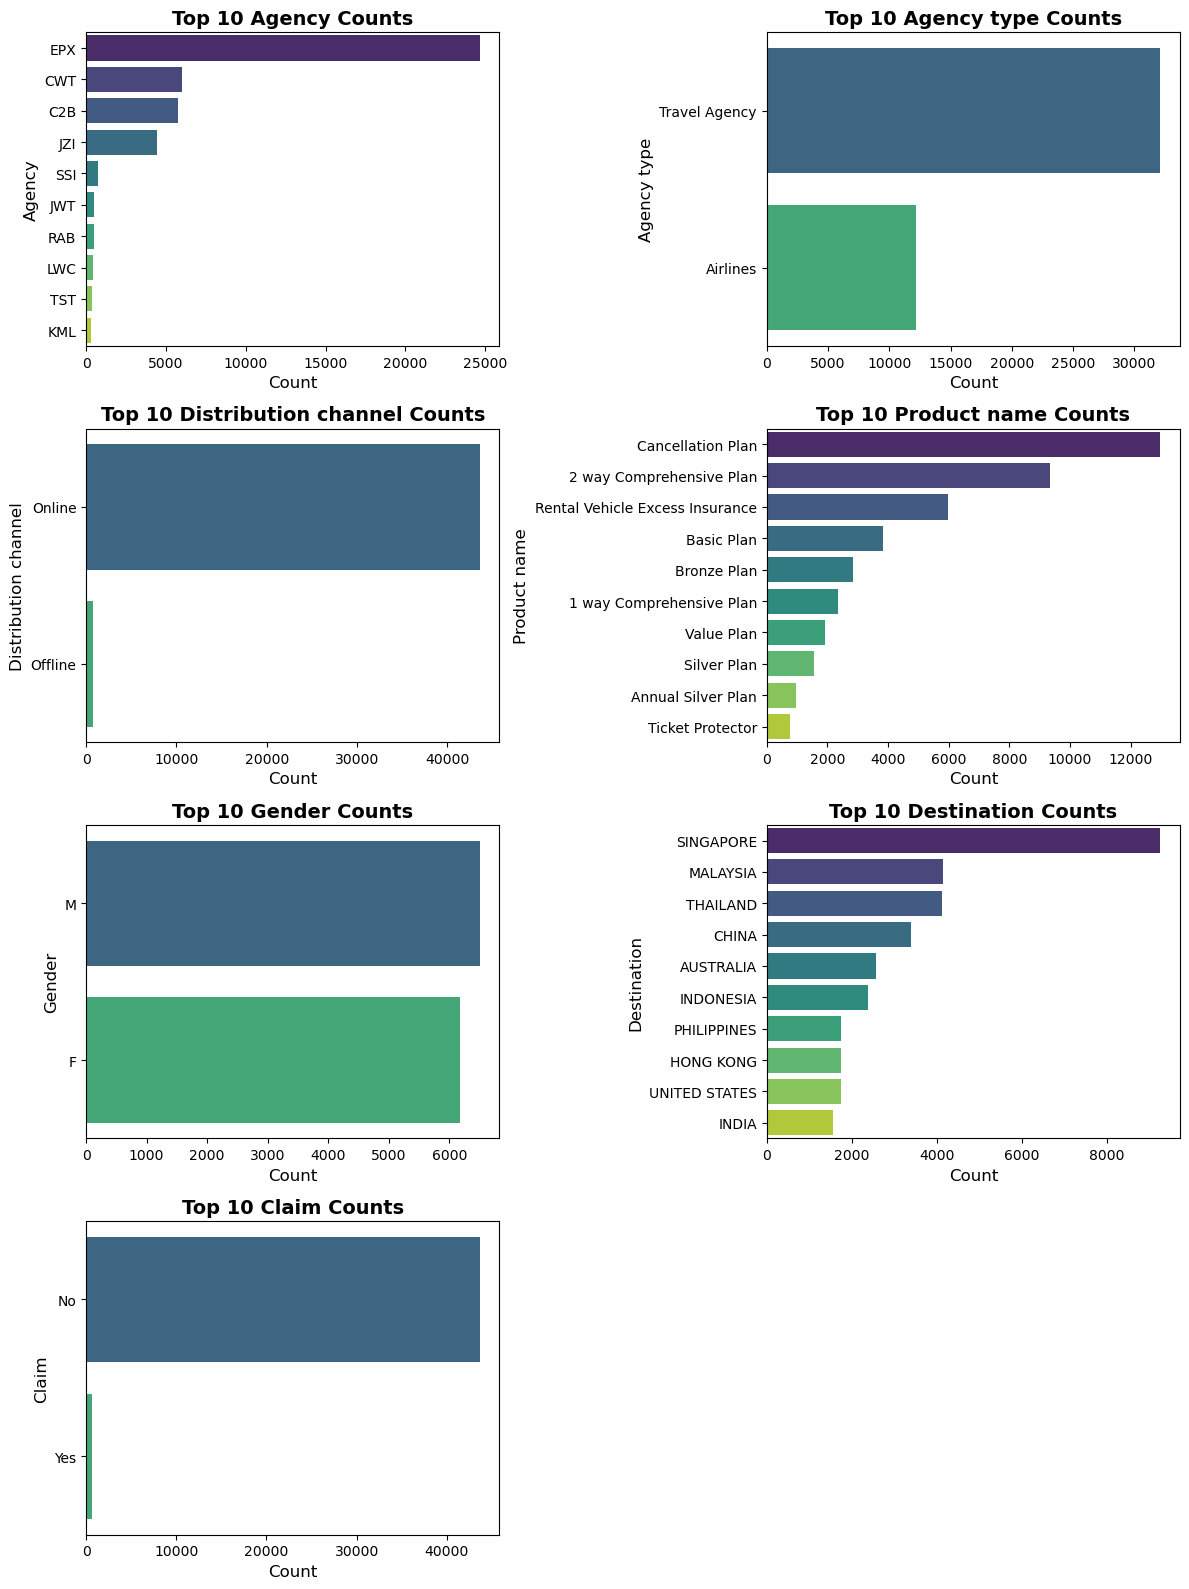

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

# Inisialisasi variabel untuk menghitung subplot
count = 0

# Membuat gambar dengan ukuran 10x10
fig = plt.figure(figsize=(12, 16))

# Iterasi melalui setiap kolom dalam DataFrame kategorikal
for kolom in df_katogerik.columns:
    # Menambahkan satu ke hitungan subplot
    count += 1
    
    # Membuat subplot dengan 4 baris dan 2 kolom, dan nomor subplot yang ditentukan
    plt.subplot(4, 2, count)
    
    # Membuat countplot untuk setiap kolom kategorikal dengan palet warna yang menarik
    sns.countplot(y=kolom, 
                  data=df_katogerik, 
                  order=df_katogerik[kolom].value_counts().sort_values(ascending=False).head(10).index, 
                  palette='viridis')
    
    # Menambahkan judul untuk setiap subplot
    plt.title('Top 10 ' + kolom.capitalize() + ' Counts', fontsize=14, weight='bold')
    
    # Menambahkan label sumbu x
    plt.xlabel('Count', fontsize=12)
    
    # Menambahkan label sumbu y
    plt.ylabel(kolom.capitalize(), fontsize=12)
    
    # Menata layout plot
    fig.tight_layout()

# Menampilkan plot
plt.show()


1. Agency: EPX adalah agen dengan jumlah transaksi terbanyak, diikuti oleh C2B.
1. Agency Type: Kebanyakan transaksi adalah dari tipe Travel Agency.
1. Distribution Channel: Hampir semua transaksi dilakukan melalui saluran online.
1. Product Name: Produk dengan nama "Cancellation Plan" dan "2-way Comprehensive Plan" adalah produk yang paling banyak dijual.
1. Destination: Kebanyakan pelanggan memilih destinasi di Asia, khususnya ke Singapura.

## Data Cleaning

In [91]:
df_copy = df

Selanjutnya kita merubah kolom 'Claim' yang merupakan kolom target menjadi nilai 0 untuk tidak Claim dan 1 untuk yang Claim

In [92]:
df_copy['Claim']= np.where(df_copy['Claim']=='Yes', 1, 0)

Selanjutnya kita merubah nama kolom `Commision (in value)` menjadi `Commision` untuk memudahkan penulisan

In [93]:
df_copy = df_copy.rename(columns = {'Commision (in value)':'Commision'})
df_copy

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision,Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.00,57,0
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.00,33,0
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.70,26,0
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.00,59,0
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.00,28,0
...,...,...,...,...,...,...,...,...,...,...,...
44323,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,14,CHINA,30.0,0.00,36,1
44324,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,NaN,17,AUSTRALIA,79.2,47.52,47,0
44325,TST,Travel Agency,Offline,Travel Cruise Protect,M,64,THAILAND,30.0,10.50,50,0
44326,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,51,CHINA,36.0,0.00,36,0


In [94]:
df_copy.isna().sum()

Agency                      0
Agency Type                 0
Distribution Channel        0
Product Name                0
Gender                  31647
Duration                    0
Destination                 0
Net Sales                   0
Commision                   0
Age                         0
Claim                       0
dtype: int64

In [95]:
df_copy.isna().sum()/len(df_copy)*100

Agency                   0.000000
Agency Type              0.000000
Distribution Channel     0.000000
Product Name             0.000000
Gender                  71.392799
Duration                 0.000000
Destination              0.000000
Net Sales                0.000000
Commision                0.000000
Age                      0.000000
Claim                    0.000000
dtype: float64

### Missing Value

Selanjutnya, kita akan memvisualisasikan missing values/data yang hilang pada dataframe kita dengan menggunakan library missingno


In [96]:
df_copy.isna().sum()

Agency                      0
Agency Type                 0
Distribution Channel        0
Product Name                0
Gender                  31647
Duration                    0
Destination                 0
Net Sales                   0
Commision                   0
Age                         0
Claim                       0
dtype: int64

In [97]:
df_copy.isna().sum()/len(df_copy)*100

Agency                   0.000000
Agency Type              0.000000
Distribution Channel     0.000000
Product Name             0.000000
Gender                  71.392799
Duration                 0.000000
Destination              0.000000
Net Sales                0.000000
Commision                0.000000
Age                      0.000000
Claim                    0.000000
dtype: float64

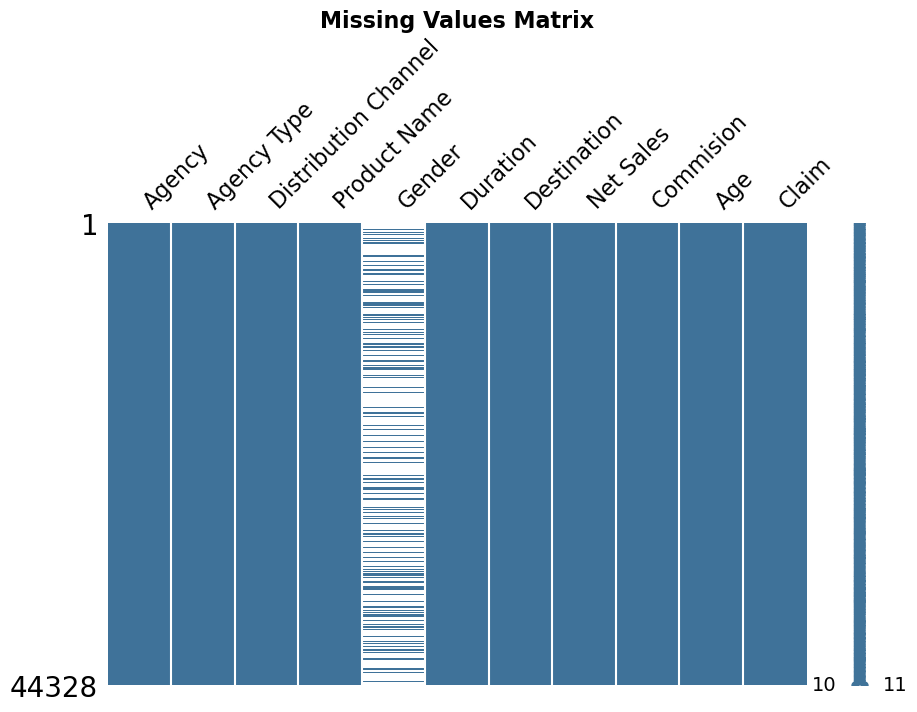

In [98]:
import missingno as msno

# Mengatur ukuran dan gaya plot
msno.matrix(df_copy, figsize=(10, 6), color=(0.25, 0.45, 0.6))

# Menambahkan judul
plt.title('Missing Values Matrix', size=16, weight='bold')

# Menampilkan plot
plt.show()


Terlihat bahwa missing value/data yang hilang pada kolom `Gender` memiliki pola yang cukup acak yang mungkin karena kesalahan penulisan atau pemegang polis tidak ingin menulis gendernya. Kolom `Gender` memiliki sekitar 71,39% nilai yang hilang. Mengingat persentase yang tinggi dari nilai yang hilang, untuk menjaga kesederhanaan dan mempertahankan sebanyak mungkin informasi, saya akan mengisi nilai-nilai yang hilang dengan placeholder seperti `Not Specific`.

In [99]:
df_copy['Gender'].fillna('Not Specific', inplace=True)

In [100]:
df_copy.isna().sum()/len(df_copy)*100

Agency                  0.0
Agency Type             0.0
Distribution Channel    0.0
Product Name            0.0
Gender                  0.0
Duration                0.0
Destination             0.0
Net Sales               0.0
Commision               0.0
Age                     0.0
Claim                   0.0
dtype: float64

### Claim (Variable Target)

In [101]:
df_copy['Claim'].value_counts()/len(df_copy)*100

Claim
0    98.472749
1     1.527251
Name: count, dtype: float64

berdasarkan dari data diatas, variable target `Claim` memiliki value data yang imbalance

In [102]:
df_copy[df_copy['Claim'] == 1]

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision,Age,Claim
13,C2B,Airlines,Online,Annual Silver Plan,F,376,SINGAPORE,252.85,63.21,43,1
21,JZI,Airlines,Online,Basic Plan,M,12,VIET NAM,30.00,10.50,35,1
28,C2B,Airlines,Online,Bronze Plan,F,30,SINGAPORE,16.00,4.00,58,1
50,LWC,Travel Agency,Online,Annual Travel Protect Gold,M,370,CHINA,204.60,132.99,39,1
102,EPX,Travel Agency,Online,2 way Comprehensive Plan,Not Specific,156,JAPAN,26.00,0.00,36,1
...,...,...,...,...,...,...,...,...,...,...,...
43963,EPX,Travel Agency,Online,2 way Comprehensive Plan,Not Specific,16,"KOREA, REPUBLIC OF",42.00,0.00,36,1
44048,C2B,Airlines,Online,Silver Plan,F,29,SINGAPORE,27.00,6.75,33,1
44182,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,Not Specific,32,AUSTRALIA,178.20,106.92,36,1
44224,C2B,Airlines,Online,Annual Silver Plan,F,390,SINGAPORE,301.00,75.25,48,1


### Kolom Durasi

In [103]:
df_copy['Duration'].describe()

count    44328.000000
mean        49.424292
std        109.153961
min         -1.000000
25%          9.000000
50%         22.000000
75%         53.000000
max       4881.000000
Name: Duration, dtype: float64

Di kolom `Duration` ini, kita memiliki nilai-nilai negatif, tetapi secara logika durasi tidak bisa negatif, selanjutnya saya akan mengubah data yang negatif menjadi data yang median

In [104]:
df10=df_copy['Duration']<0
df10.sum()

2

jadi, ada 2 nilai negatif dalam kolom `Duration`. Saya akan menggantinya dengan nilai median karena distribusi data tidak mengikuti pola normal.

In [105]:
median_duration = df_copy['Duration'].median()
df_copy['Duration'] = np.where(df_copy['Duration'] < 0, median_duration, df_copy['Duration'])


In [106]:
df_copy['Duration'].describe()

count    44328.000000
mean        49.425329
std        109.153591
min          0.000000
25%          9.000000
50%         22.000000
75%         53.000000
max       4881.000000
Name: Duration, dtype: float64

### Data Duplikat

In [107]:
df_copy[df_copy.duplicated(keep='first')].shape

(4667, 11)

ada 4.667 baris duplikat dalam dataset ini. Untuk menjaga integritas data, kita sebaiknya menghapus duplikat-duplikat ini untuk menurunkan kemungkinan model terjadi overfitting.

In [108]:
df_copy[df_copy.duplicated(keep='first')].sort_values(['Product Name','Duration', 'Age']).head()

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision,Age,Claim
39757,EPX,Travel Agency,Online,1 way Comprehensive Plan,Not Specific,1.0,THAILAND,20.0,0.0,28,0
2066,EPX,Travel Agency,Online,1 way Comprehensive Plan,Not Specific,1.0,SINGAPORE,20.0,0.0,36,0
2908,EPX,Travel Agency,Online,1 way Comprehensive Plan,Not Specific,1.0,SINGAPORE,20.0,0.0,36,0
3698,EPX,Travel Agency,Online,1 way Comprehensive Plan,Not Specific,1.0,VIET NAM,20.0,0.0,36,0
5820,EPX,Travel Agency,Online,1 way Comprehensive Plan,Not Specific,1.0,VIET NAM,20.0,0.0,36,0


In [109]:
df_copy = df_copy.drop_duplicates(keep='first').reset_index(drop=True)
df_copy.shape 

(39661, 11)

### Kolom Age

Untuk kolom `Age`, kita perlu melakukan investigasi lebih lanjut untuk menentukan tindakan yang sesuai terhadap outliers yang diidentifikasi sebelumnya.

In [110]:
df_copy['Age'].describe()

count    39661.000000
mean        39.930284
std         13.526346
min          0.000000
25%         34.000000
50%         36.000000
75%         45.000000
max        118.000000
Name: Age, dtype: float64

Untuk kolom Usia:

Usia maksimum adalah 118, yang juga patut dicurigai karena sangat jarang bagi individu berusia sejauh ini untuk melakukan perjalanan atau membeli asuransi perjalanan.

Untuk mengatasi nilai-nilai ekstrem dalam kolom Usia, kami akan membatasi usia minimum menjadi 0 dan usia maksimum menjadi 100. Nilai-nilai di luar rentang ini akan diatur ulang ke ambang batas ini.

In [111]:
# Capping the age values
df_copy['Age'] = np.where(df_copy['Age'] > 100, 100, df_copy['Age'])

# Display the updated statistics for the 'Age' column
df_copy['Age'].describe()


count    39661.000000
mean        39.712892
std         12.364609
min          0.000000
25%         34.000000
50%         36.000000
75%         45.000000
max        100.000000
Name: Age, dtype: float64

Skewness of Duration: 24.338167400763847
Kurtosis of Duration: 975.1490844825742


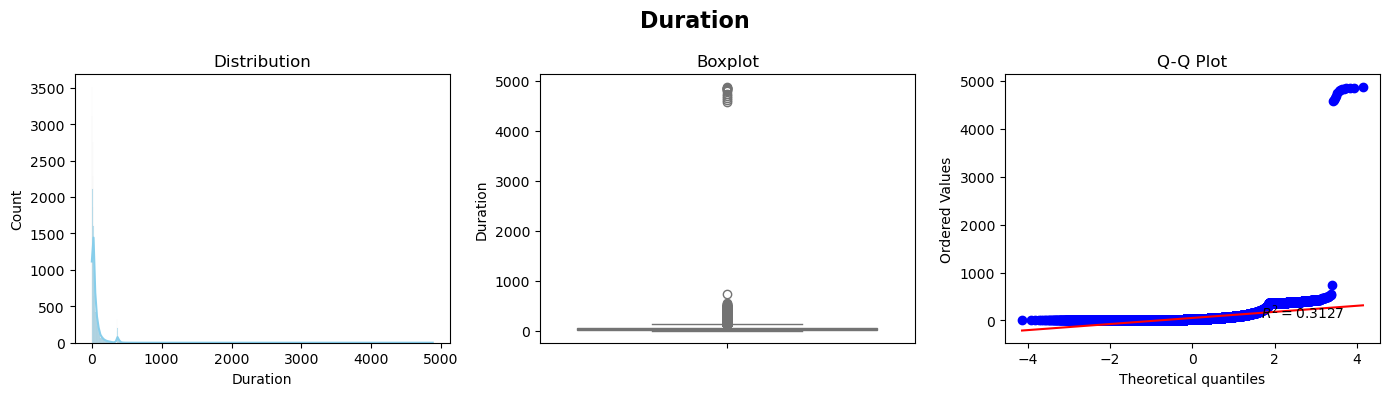

Skewness of Net Sales: 3.2093319434807923
Kurtosis of Net Sales: 18.778520162857312


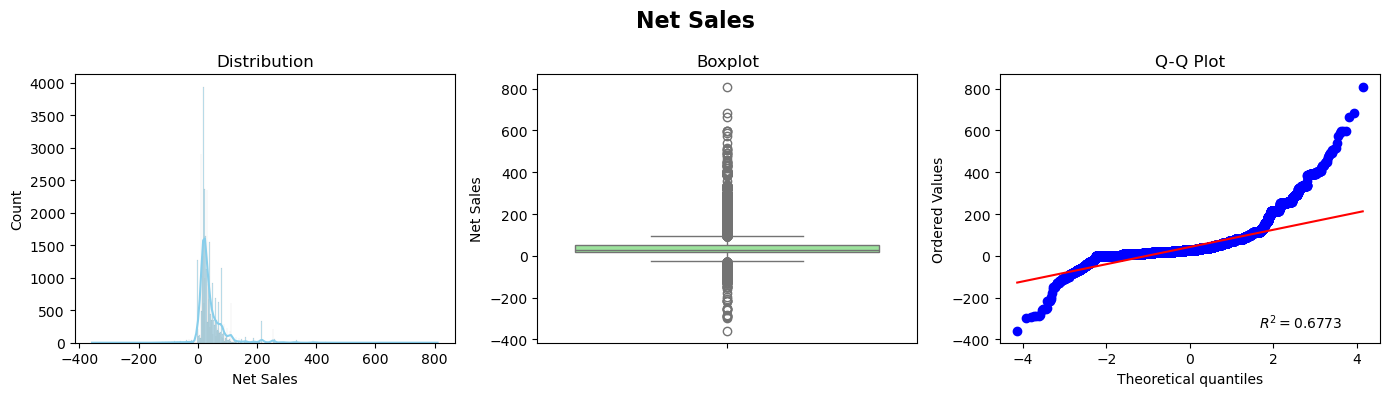

Skewness of Commision: 3.9160831256182216
Kurtosis of Commision: 23.703904257834065


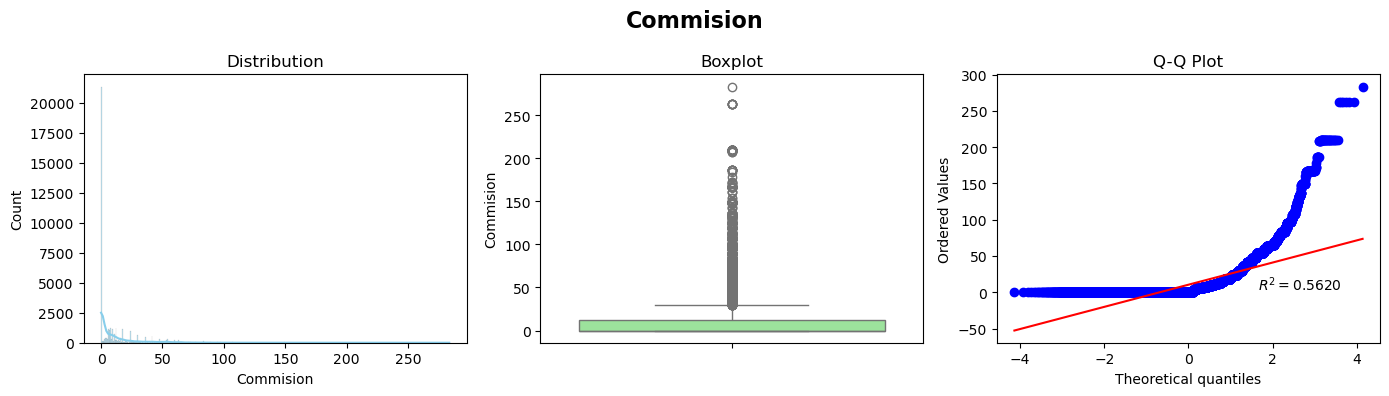

Skewness of Age: 1.9398142571851034
Kurtosis of Age: 6.0110310339509185


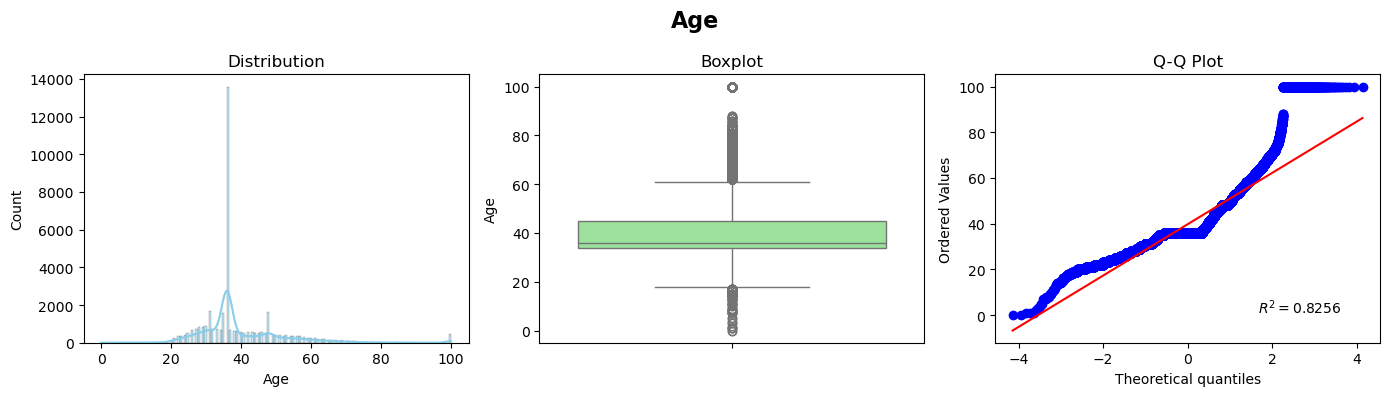

Skewness of Claim: 7.468505209155555
Kurtosis of Claim: 53.78128210536232


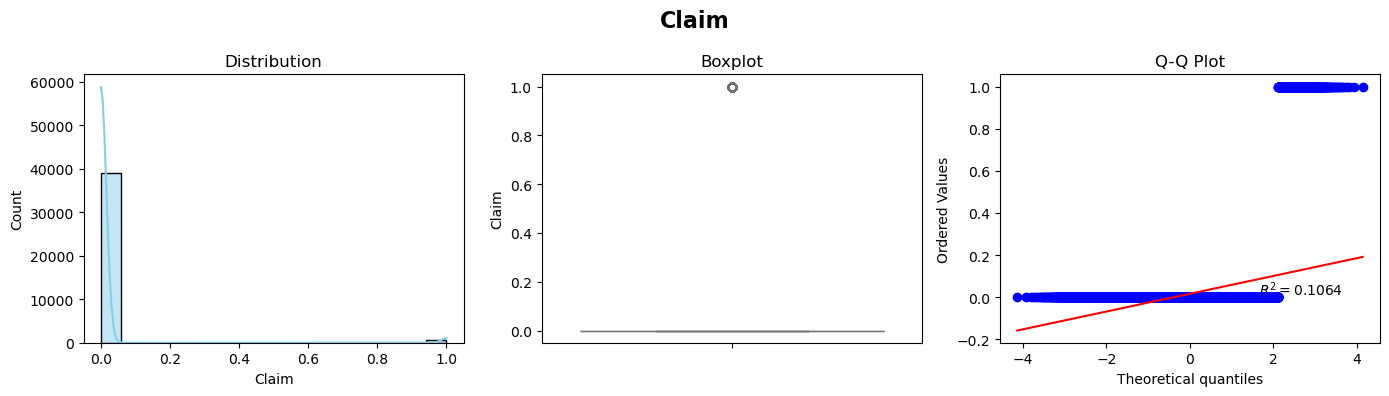

In [112]:
from scipy.stats import probplot

# Iterasi melalui setiap kolom numerik dalam DataFrame
for col in df_copy.select_dtypes(np.number).columns:
    # Menampilkan skewness dan kurtosis
    print(f"Skewness of {col}: {df_copy[col].skew()}")
    print(f"Kurtosis of {col}: {df_copy[col].kurtosis()}")
    
    # Membuat gambar dengan ukuran 14x4 untuk setiap kolom
    plt.figure(figsize=(14, 4))
    
    # Menampilkan distribusi data menggunakan histogram
    plt.subplot(131)
    sns.histplot(df_copy[col], kde=True, color='skyblue')
    plt.title('Distribution')
    
    # Menampilkan boxplot
    plt.subplot(132)
    sns.boxplot(df_copy[col], color='lightgreen')
    plt.title('Boxplot')
    
    # Menampilkan Q-Q plot untuk normalitas
    plt.subplot(133)
    probplot(df_copy[col], plot=plt, rvalue=True, dist='norm')
    plt.title('Q-Q Plot')
    
    # Menambahkan judul untuk setiap kolom
    plt.suptitle(col, fontsize=16, weight='bold', color='black')
    
    # Menata layout plot
    plt.tight_layout()
    
    # Menampilkan plot
    plt.show()


## EDA

In [113]:
# Cek info lebih detail untuk setiap fitur
listItem = []

for col in df_copy.columns:
    listItem.append([col, df_copy[col].dtype, df_copy[col].isna().sum(), round((df_copy[col].isna().sum()/len(df_copy[col]))*100, 2),
                    df_copy[col].nunique(), list(df_copy[col].drop_duplicates().sample(2).values)])

pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,Agency,object,0,0.0,16,"[CCR, EPX]"
1,Agency Type,object,0,0.0,2,"[Airlines, Travel Agency]"
2,Distribution Channel,object,0,0.0,2,"[Online, Offline]"
3,Product Name,object,0,0.0,26,"[1 way Comprehensive Plan, Annual Silver Plan]"
4,Gender,object,0,0.0,3,"[F, M]"
5,Duration,float64,0,0.0,436,"[236.0, 238.0]"
6,Destination,object,0,0.0,138,"[KOREA, REPUBLIC OF, CHINA]"
7,Net Sales,float64,0,0.0,1006,"[140.0, 11.5]"
8,Commision,float64,0,0.0,915,"[70.2, 28.35]"
9,Age,int64,0,0.0,89,"[44, 71]"


### Berdasarkan umur

In [114]:
bins = list(range(0,100,5))
bins
labels = []
for i in range(len(bins)-1):
    label = '{} - {}'.format(bins[i],bins[i+1])
    labels.append(label)
df_copy['age_group'] = pd.cut(df_copy['Age'], bins=bins, labels=labels, right=False)
df_copy

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision,Age,Claim,age_group
0,C2B,Airlines,Online,Annual Silver Plan,F,365.0,SINGAPORE,216.0,54.00,57,0,55 - 60
1,EPX,Travel Agency,Online,Cancellation Plan,Not Specific,4.0,MALAYSIA,10.0,0.00,33,0,30 - 35
2,JZI,Airlines,Online,Basic Plan,M,19.0,INDIA,22.0,7.70,26,0,25 - 30
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,Not Specific,20.0,UNITED STATES,112.0,0.00,59,0,55 - 60
4,C2B,Airlines,Online,Bronze Plan,M,8.0,SINGAPORE,16.0,4.00,28,0,25 - 30
...,...,...,...,...,...,...,...,...,...,...,...,...
39656,EPX,Travel Agency,Online,2 way Comprehensive Plan,Not Specific,14.0,CHINA,30.0,0.00,36,1,35 - 40
39657,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,Not Specific,17.0,AUSTRALIA,79.2,47.52,47,0,45 - 50
39658,TST,Travel Agency,Offline,Travel Cruise Protect,M,64.0,THAILAND,30.0,10.50,50,0,50 - 55
39659,EPX,Travel Agency,Online,2 way Comprehensive Plan,Not Specific,51.0,CHINA,36.0,0.00,36,0,35 - 40


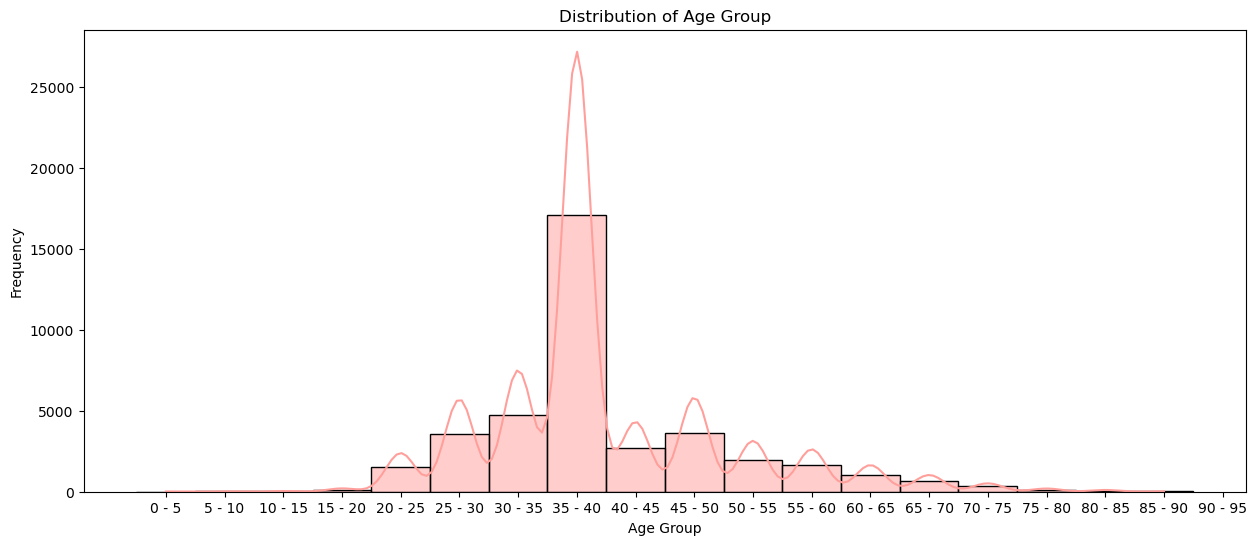

In [115]:
# Import library yang diperlukan
import matplotlib.pyplot as plt
import seaborn as sns

palette = sns.color_palette("pastel")

# Plot distribusi usia
plt.figure(figsize=(15, 6))
sns.histplot(df_copy['age_group'], kde=True, bins=30, color=palette[3])

# Menambahkan judul plot
plt.title('Distribution of Age Group')

# Menambahkan label sumbu x
plt.xlabel('Age Group')

# Menambahkan label sumbu y
plt.ylabel('Frequency')

# Menampilkan plot
plt.show()


Distribusi kelompok umur dari pemilik asuransi perjalanan cenderung di tengah, dengan sebagian besar Distribusi umur pelanggan cenderung menceng ke kanan, dengan sebagian besar pelanggan berusia di bawah 60 tahun. berusia di antara 35 - 40 tahun.

### Berdasarkan destinasi

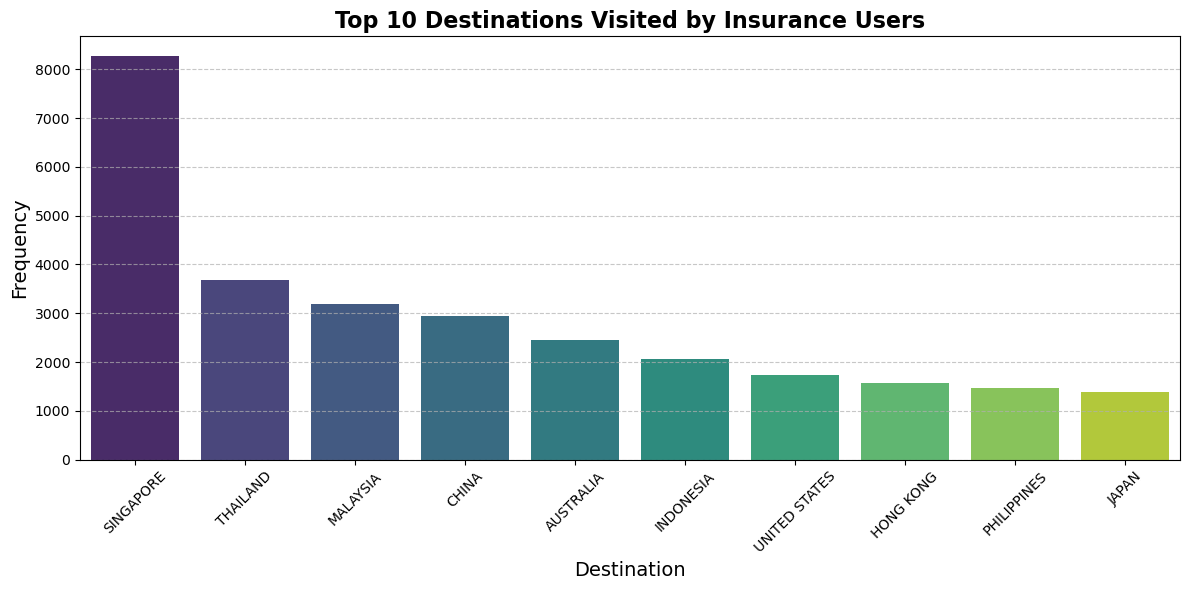

In [118]:
# Import library yang diperlukan
import matplotlib.pyplot as plt
import seaborn as sns

# Menghitung jumlah destinasi
destination_count = df_copy['Destination'].value_counts().head(10)

# Memilih palet warna berdasarkan jumlah destinasi
palette = sns.color_palette("viridis", len(destination_count))

# Plot penjualan destinasi
plt.figure(figsize=(12, 6))
sns.barplot(x=destination_count.index, y=destination_count.values, palette=palette)

# Menambahkan judul plot dengan ukuran dan gaya yang lebih besar, serta warna teks hitam
plt.title('Top 10 Destinations Visited by Insurance Users', fontsize=16, weight='bold', color='black')

# Menambahkan label sumbu x dengan ukuran dan warna teks yang lebih besar
plt.xlabel('Destination', fontsize=14, color='black')

# Menambahkan label sumbu y dengan ukuran dan warna teks yang lebih besar
plt.ylabel('Frequency', fontsize=14, color='black')

# Putar label sumbu x untuk meningkatkan kejelasan
plt.xticks(rotation=45)

# Tambahkan grid horizontal untuk mempermudah membaca data
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Menata layout plot
plt.tight_layout()

# Menampilkan plot
plt.show()


Dari visualisasi di atas, kita dapat melihat bahwa "Singapore" adalah destinasi yang paling banyak dikunjungi oleh pengguna asuransi, diikuti oleh "Thailand" dan "Malaysia". Ini mungkin menunjukkan bahwa destinasi tersebut populer di kalangan wisatawan dan memiliki risiko yang lebih tinggi yang memotivasi pengguna untuk membeli asuransi perjalanan.

### Berdasarkan produk

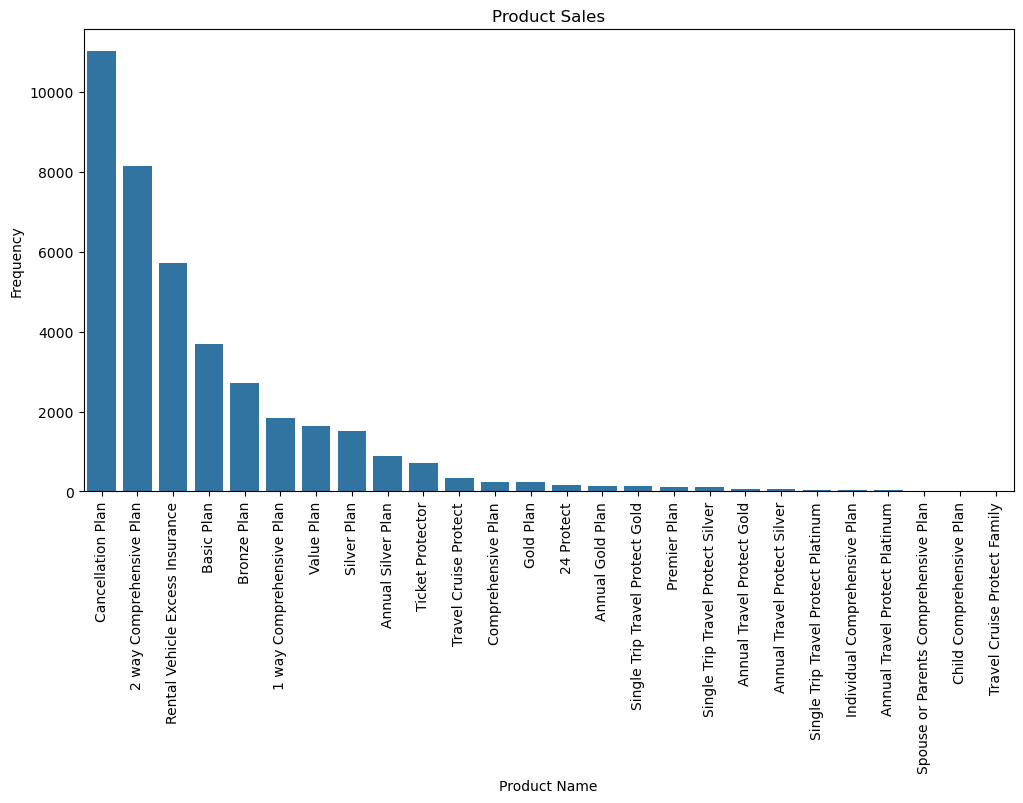

In [119]:
# Mengimpor library yang diperlukan
import matplotlib.pyplot as plt
import seaborn as sns

# Membuat plot dengan ukuran yang diinginkan
plt.figure(figsize=(12, 6))

# Menghitung jumlah penjualan untuk setiap produk
product_count = df_copy['Product Name'].value_counts()

# Membuat plot bar menggunakan seaborn
sns.barplot(x=product_count.index, y=product_count.values)

# Menambahkan judul plot
plt.title('Product Sales')

# Menambahkan label sumbu x
plt.xlabel('Product Name')

# Menambahkan label sumbu y
plt.ylabel('Frequency')

# Memutar label sumbu x untuk meningkatkan kejelasan
plt.xticks(rotation=90)

# Menampilkan plot
plt.show()


Dari visualisasi di atas, kita dapat melihat bahwa "Cancellation Plan" adalah produk asuransi yang paling laris, diikuti oleh "2 way Comprehensive Plan" dan "Rental Vehicle Excess Insurance". Produk "Cancellation Plan" mungkin memiliki fitur atau harga yang menarik bagi pelanggan, sehingga menjadi pilihan yang populer.

In [120]:
# Group data by product name and calculate total net sales and total commission
product_profit = df_copy.groupby('Product Name').agg({'Net Sales': 'sum', 'Commision': 'sum'}).sort_values(by='Net Sales', ascending=False).reset_index()
product_profit.head()

,Product Name,Net Sales,Commision
0,2 way Comprehensive Plan,362932.00,0.00
1,Cancellation Plan,312061.00,0.00
2,Rental Vehicle Excess Insurance,246153.60,187371.36
3,Annual Silver Plan,196670.01,51220.41
4,Basic Plan,98665.00,35483.70


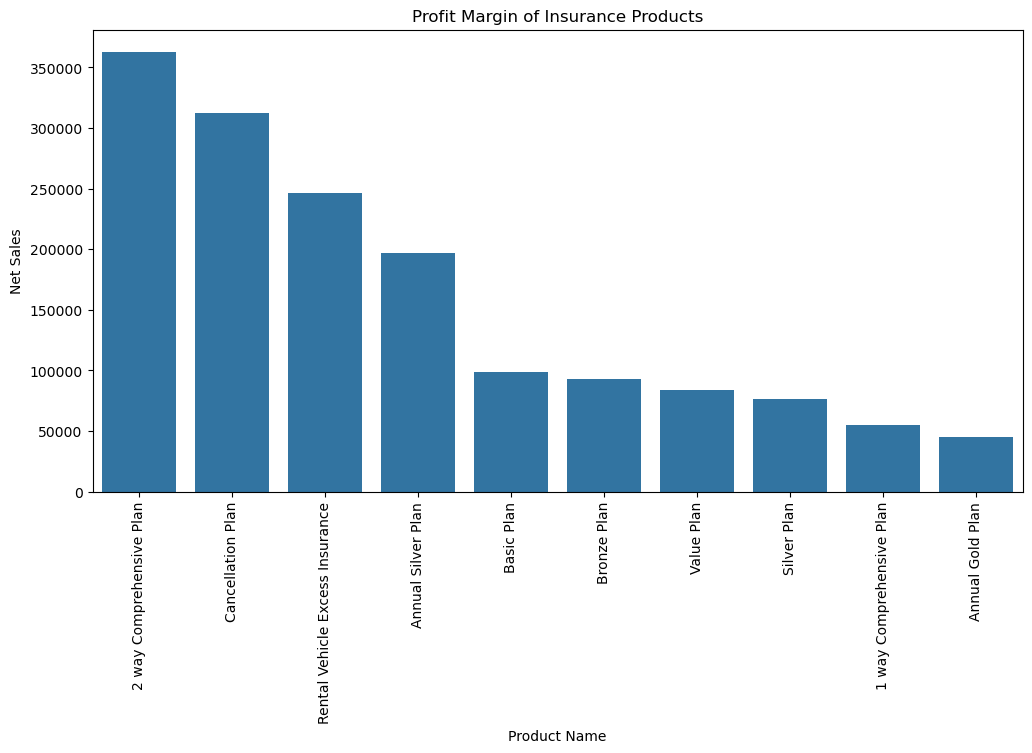

In [121]:
# Membuat plot dengan ukuran yang diinginkan
plt.figure(figsize=(12, 6))

# Membuat plot bar menggunakan seaborn dengan data yang diberikan
sns.barplot(x='Product Name', y='Net Sales', data=product_profit.head(10))

# Menambahkan judul plot
plt.title('Profit Margin of Insurance Products')

# Menambahkan label sumbu x
plt.xlabel('Product Name')

# Menambahkan label sumbu y
plt.ylabel('Net Sales')

# Memutar label sumbu x untuk meningkatkan kejelasan
plt.xticks(rotation=90)

# Menampilkan plot
plt.show()


Namun, berdasarkan dari visualisasi di atas, kita dapat melihat bahwa produk "2 way Comprehensive Plan" memiliki net sales yang paling tinggi daripada "Cancellation Plan", sehingga "2 way Comprehensive Plan" merupakan produk asuransi yang paling menguntungkan. Produk "Rental Vehicle Excess Insurance", "Annual Silver Plan", dan "Basic Plan" juga menguntungkan, namun net salesnya lebih rendah dibandingkan dua produk pertama.

### Berdasarkan Agency

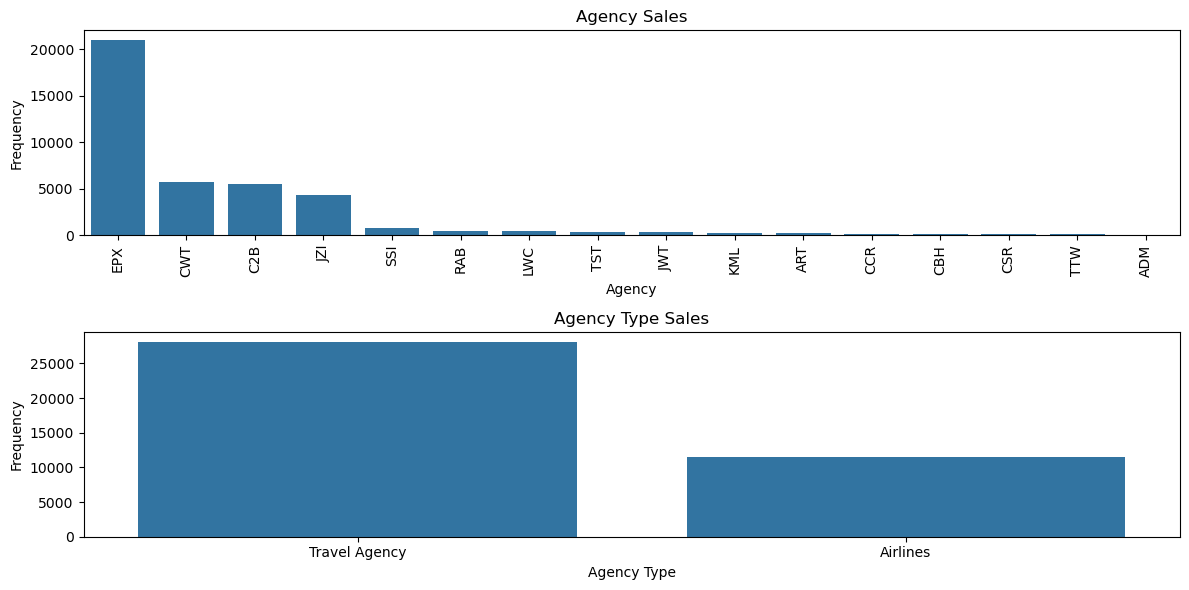

In [122]:
# Membuat plot dengan ukuran yang diinginkan
plt.figure(figsize=(12, 6))

# Subplot 1: Agency Sales
plt.subplot(2, 1, 1)

# Menghitung jumlah penjualan untuk setiap agen
agency_count = df_copy['Agency'].value_counts()

# Membuat plot bar menggunakan seaborn untuk penjualan agen
sns.barplot(x=agency_count.index, y=agency_count.values)

# Menambahkan judul subplot 1
plt.title('Agency Sales')

# Menambahkan label sumbu x pada subplot 1
plt.xlabel('Agency')

# Menambahkan label sumbu y pada subplot 1
plt.ylabel('Frequency')

# Memutar label sumbu x pada subplot 1 untuk meningkatkan kejelasan
plt.xticks(rotation=90)

# Subplot 2: Agency Type Sales
plt.subplot(2, 1, 2)

# Menghitung jumlah penjualan untuk setiap jenis agen
agency_type_count = df_copy['Agency Type'].value_counts()

# Membuat plot bar menggunakan seaborn untuk penjualan jenis agen
sns.barplot(x=agency_type_count.index, y=agency_type_count.values)

# Menambahkan judul subplot 2
plt.title('Agency Type Sales')

# Menambahkan label sumbu x pada subplot 2
plt.xlabel('Agency Type')

# Menambahkan label sumbu y pada subplot 2
plt.ylabel('Frequency')

# Menata layout plot secara rapi
plt.tight_layout()

# Menampilkan plot
plt.show()


Dari visualisasi di atas, kita dapat menyimpulkan beberapa hal:

1. **EPX** adalah agensi dengan frekuensi penjualan asuransi perjalanan tertinggi, diikuti oleh **C2B** dan **JZI**. Hal ini menunjukkan bahwa agensi tersebut memiliki pengaruh yang signifikan dalam penjualan asuransi perjalanan.

2. Dilihat dari tipe agensi, **Travel Agency** memiliki frekuensi penjualan asuransi perjalanan yang paling tinggi dibandingkan dengan **Airlines**. Hal ini menunjukkan bahwa agensi perjalanan memainkan peran penting dalam industri asuransi perjalanan.

Informasi ini dapat memberikan wawasan yang berharga bagi perusahaan asuransi dalam mengidentifikasi agensi dan tipe agensi yang paling berpengaruh dalam penjualan asuransi perjalanan, sehingga mereka dapat mengarahkan upaya pemasaran dan strategi bisnis mereka secara lebih efektif.

In [123]:
# Group data by agency name and calculate total net sales and total commission
agency_profit = df_copy.groupby(['Agency']).agg({'Net Sales': 'sum', 'Commision': 'sum'}).sort_values(by='Net Sales', ascending=False).reset_index()
agency_profit.head()

,Agency,Net Sales,Commision
0,EPX,729660.00,0.00
1,C2B,431089.71,112548.52
2,CWT,246153.60,187371.36
3,JZI,140572.00,50975.75
4,LWC,50326.20,33435.55


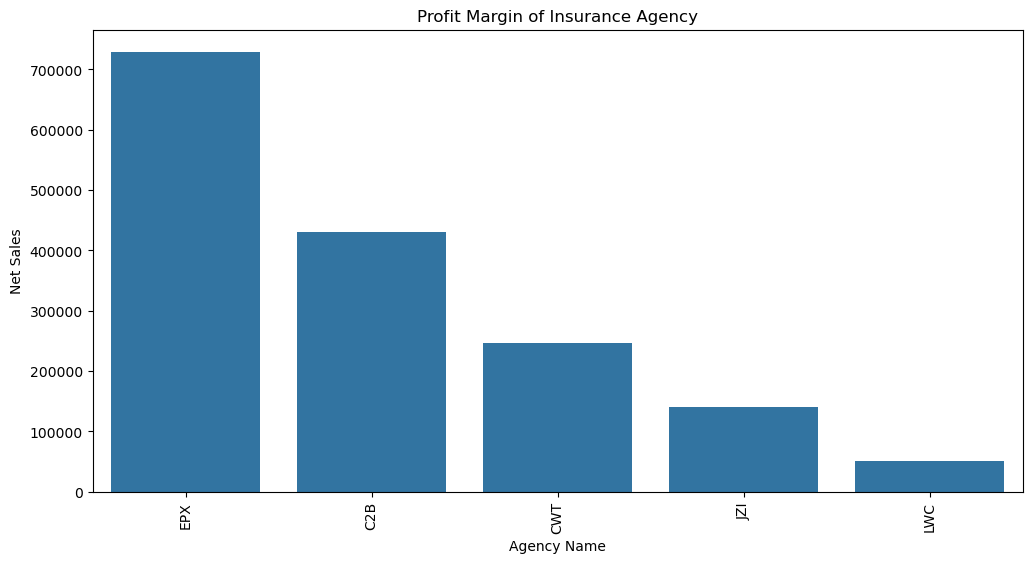

In [124]:
# Membuat plot dengan ukuran yang diinginkan
plt.figure(figsize=(12, 6))

# Membuat plot bar menggunakan seaborn dengan data yang diberikan
sns.barplot(x='Agency', y='Net Sales', data=agency_profit.head())

# Menambahkan judul plot
plt.title('Profit Margin of Insurance Agency')

# Menambahkan label sumbu x
plt.xlabel('Agency Name')

# Menambahkan label sumbu y
plt.ylabel('Net Sales')

# Memutar label sumbu x untuk meningkatkan kejelasan
plt.xticks(rotation=90)

# Menampilkan plot
plt.show()


Namun, berdasarkan dari visualisasi di atas, kita dapat melihat bahwa "EPX" adalah agensi yang paling banyak mendapatkan keuntungan dalam menjual asuransi perjalanan dengan nilai 729.660, diikuti oleh "C2B" dan "JZI".

In [125]:
# Group data by agency type and calculate total net sales and total commission
agencytype_profit = df_copy.groupby(['Agency Type']).agg({'Net Sales': 'sum', 'Commision': 'sum'}).sort_values(by='Net Sales', ascending=False).reset_index()
agencytype_profit.head()

,Agency Type,Net Sales,Commision
0,Travel Agency,1067559.80,235026.24
1,Airlines,611797.74,179138.61


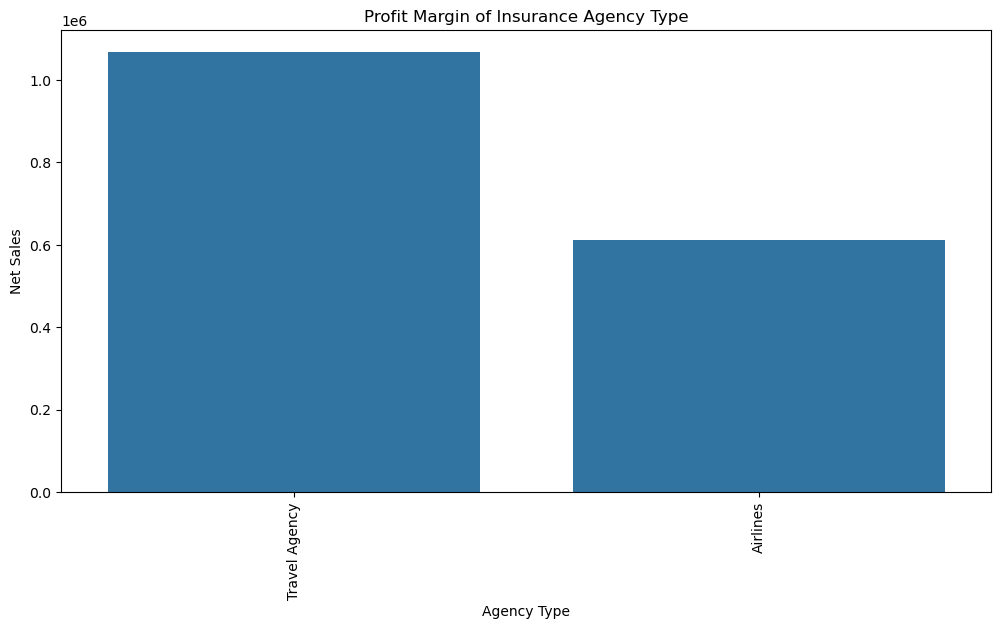

In [126]:
# Membuat plot dengan ukuran yang diinginkan
plt.figure(figsize=(12, 6))

# Membuat plot bar menggunakan seaborn dengan data yang diberikan
sns.barplot(x='Agency Type', y='Net Sales', data=agencytype_profit)

# Menambahkan judul plot
plt.title('Profit Margin of Insurance Agency Type')

# Menambahkan label sumbu x
plt.xlabel('Agency Type')

# Menambahkan label sumbu y
plt.ylabel('Net Sales')

# Memutar label sumbu x untuk meningkatkan kejelasan
plt.xticks(rotation=90)

# Menampilkan plot
plt.show()


Berdasarkan visualisasi diatas, tipe "Travel Agency" memiliki proporsi keuntungan yang hampir 2 kali lipat dibandingkan dengan tipe "Airlines".

## Data Preprocecing

### Data Splitting

In [127]:
# Memisahkan fitur dan target
X = df_copy.drop(columns=['Claim', 'age_group'])
y = df_copy['Claim']

# Membagi data menjadi data latih dan data uji
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X,
    y,
    test_size=0.2,  # Proporsi data uji: 20%
    stratify=y,    # Mempertahankan proporsi kelas target di data uji dan data latih
    random_state=2020  # Seed untuk reproduktibilitas
)


In [128]:
y.value_counts()*100 / len(y)

Claim
0    98.298076
1     1.701924
Name: count, dtype: float64

In [129]:
df_copy.select_dtypes(include='object').nunique()

Agency                   16
Agency Type               2
Distribution Channel      2
Product Name             26
Gender                    3
Destination             138
dtype: int64

In [130]:
# Menggunakan ColumnTransformer untuk melakukan transformasi fitur
transformer = ColumnTransformer([
    # One-Hot Encoding untuk fitur kategorikal dengan lebih dari 2 kategori
    ('one hot encoder', OneHotEncoder(drop='first'), ['Agency Type', 'Distribution Channel', 'Gender']),
    # Binary Encoding untuk fitur kategorikal dengan banyak kategori
    ('binary encoder', ce.BinaryEncoder(), ['Agency', 'Product Name', 'Destination']),
], remainder='passthrough')  # Mempertahankan fitur-fitur lainnya tanpa transformasi


In [131]:
# Membuat DataFrame baru dari hasil transformasi fitur
testing = pd.DataFrame(transformer.fit_transform(X_train_val), columns=transformer.get_feature_names_out())

# Menampilkan lima baris pertama dari DataFrame baru
testing.head()


,one hot encoder__Agency Type_Travel Agency,one hot encoder__Distribution Channel_Online,one hot encoder__Gender_M,one hot encoder__Gender_Not Specific,binary encoder__Agency_0,binary encoder__Agency_1,binary encoder__Agency_2,binary encoder__Agency_3,binary encoder__Agency_4,binary encoder__Product Name_0,...,binary encoder__Destination_2,binary encoder__Destination_3,binary encoder__Destination_4,binary encoder__Destination_5,binary encoder__Destination_6,binary encoder__Destination_7,remainder__Duration,remainder__Net Sales,remainder__Commision,remainder__Age
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,18.0,53.5,13.38,53.0
1,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,19.0,80.0,0.00,36.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,7.0,13.5,3.38,56.0
3,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,36.0,80.0,0.00,36.0
4,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,111.0,49.0,0.00,36.0


## Modelling & Evaluation

In [132]:
# Mendefinisikan model-model klasifikasi
logreg = LogisticRegression(solver='liblinear')
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=2023)
rf = RandomForestClassifier(random_state=2023)
abc = AdaBoostClassifier(random_state=2023)
xgb = XGBClassifier(random_state=2023)
lgbm = lgb.LGBMClassifier(random_state=2023)
gbc = GradientBoostingClassifier(random_state=2023)

# Menggunakan RobustScaler untuk penskalaan fitur
scaler = RobustScaler()

# Membuat objek StratifiedKFold untuk digunakan dalam validasi silang
skfold = StratifiedKFold(n_splits=5)


In [133]:
# Mendefinisikan list model yang akan dievaluasi
models = [logreg, knn, dt, rf, abc, xgb, lgbm, gbc]

# List untuk menyimpan nama model, skor rata-rata, dan standar deviasi
list_model = []
score = []
std = []

# Melakukan validasi silang dan memperoleh skor recall untuk setiap model
for i in models:
    estimator = Pipeline([
        ('preprocess', transformer),
        ('scaler', scaler),
        ('model', i)
    ])
    model_cv = cross_val_score(estimator, X_train_val, y_train_val, cv=skfold, scoring='recall')

    # Menyimpan nama model, skor rata-rata, dan standar deviasi
    list_model.append(i)
    score.append(model_cv.mean())
    std.append(model_cv.std())

# Membuat DataFrame untuk menampilkan hasil evaluasi model
model_evaluation = pd.DataFrame({
    'model': ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'AdaBoost', 'XGBoost', 'LightGBM', 'Gradient Boosting'],
    'recall_score': score,
    'std_deviation': std
}).set_index('model').sort_values(by='recall_score', ascending=False)

# Menampilkan DataFrame hasil evaluasi model
model_evaluation


[LightGBM] [Info] Number of positive: 432, number of negative: 24950
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 870
[LightGBM] [Info] Number of data points in the train set: 25382, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.017020 -> initscore=-4.056204
[LightGBM] [Info] Start training from score -4.056204
[LightGBM] [Info] Number of positive: 432, number of negative: 24950
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 873
[LightGBM] [Info] Number of data points in the train set: 25382, number of used features: 25
[LightGBM] [Info] [binar

,recall_score,std_deviation
model,,
Decision Tree,0.061111,0.016144
KNN,0.005556,0.004536
XGBoost,0.003704,0.004536
LightGBM,0.001852,0.003704
Logistic Regression,0.000000,0.000000
Random Forest,0.000000,0.000000
AdaBoost,0.000000,0.000000
Gradient Boosting,0.000000,0.000000


Dari tabel diatas, terlihat bahwa model Decision Tree adalah yang terbaik untuk recall_score dengan nilai 0.061111 dan standar deviasinya 0.015045 dari setiap model yang menggunakan default hyperparameter tetapi tanpa resampling value data target minoritas (1)

selanjutnya mari kita coba benchmarking model pada test data tanpa resampling

### Model Benchmarking : Test Data tanpa Resampling

In [134]:
# Menggunakan RobustScaler untuk penskalaan fitur
scaler = RobustScaler()

# Mendefinisikan model Decision Tree
dt = DecisionTreeClassifier(random_state=2023)

# Membuat pipeline untuk pengolahan data dan model Decision Tree
model_test_data = Pipeline([
    ('preprocess', transformer),
    ('scaler', scaler),
    ('model', dt)    
])

# Melatih model pada data latih dan validasi
model_test_data.fit(X_train_val, y_train_val)

# Melakukan prediksi pada data uji
y_pred = model_test_data.predict(X_test)

# Menampilkan laporan klasifikasi untuk evaluasi performa model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      0.98      0.98      7798
           1       0.07      0.10      0.08       135

    accuracy                           0.96      7933
   macro avg       0.53      0.54      0.53      7933
weighted avg       0.97      0.96      0.96      7933



Dari tabel diatas, terlihat bahwa model Decision Tree tanpa resampling masih terlalu kompleks dan masih overfitting karena value data dari kolom target minoritas nilainya 0 untuk precision dan recall. selanjutnya mari kita cek proporsi value data target

In [135]:
y_train_val.value_counts()*100 / len(y_train_val)

Claim
0    98.298033
1     1.701967
Name: count, dtype: float64

In [136]:
y_train_val.value_counts()


Claim
0    31188
1      540
Name: count, dtype: int64

Dari analisis tersebut, terlihat bahwa proporsi data target untuk kategori 1 tidak sebanding dengan kategori 0, dengan proporsi sebesar 1.710%. Kondisi ini dapat dikategorikan sebagai Moderate Imbalance, yang mengindikasikan bahwa ada ketidakseimbangan yang signifikan antara kelas positif dan negatif dalam dataset. Hal ini perlu diperhatikan karena ketidakseimbangan kelas dapat mempengaruhi kinerja dan interpretasi model machine learning, terutama dalam konteks klasifikasi. Strategi penanganan khusus mungkin diperlukan untuk mengatasi masalah ini, seperti penggunaan metode resampling atau algoritma khusus yang dapat menangani ketidakseimbangan kelas.


Langkah selanjutnya adalah melakukan benchmarking model dengan menggunakan beberapa metode resampling. Resampling adalah teknik yang digunakan untuk menyeimbangkan dataset dengan cara mengubah distribusi sampelnya. Dalam konteks ini, kita akan mencoba beberapa metode resampling untuk menyeimbangkan proporsi kelas dalam dataset, seperti oversampling dan undersampling.

### Model Benchmarking: menggunakan resampler

In [137]:
samplers = [SMOTE(random_state=2023), NearMiss(sampling_strategy='auto'), RandomOverSampler(random_state=2023)]


In [138]:
# List model yang akan dievaluasi
models = [logreg, knn, dt, rf, abc, xgb, lgbm, gbc]

# List untuk menyimpan model, teknik sampling, skor rata-rata, dan standar deviasi
list_model = []
list_sampling = []
score = []
std = []

# Melakukan evaluasi model dengan berbagai teknik sampling
for sampler in samplers:
    for model in models:
        # Menggunakan pipeline untuk preprocessing, balancing, dan model
        model_cv = cross_val_score(
            estimator=Pipeline([
                ('preprocess', transformer),
                ('scaler', scaler),
                ('balancing', sampler), 
                ('model', model)
            ]),
            X=X_train_val,
            y=y_train_val,
            cv=skfold,
            scoring='recall',
            error_score='raise',
            n_jobs=-1
        )

        # Menyimpan model, teknik sampling, skor rata-rata, dan standar deviasi
        list_sampling.append(sampler)
        list_model.append(model)
        score.append(model_cv.mean())
        std.append(model_cv.std())

# Membuat DataFrame untuk menampilkan hasil evaluasi model dengan berbagai teknik sampling
model_evaluation_sampling = pd.DataFrame({
    'model': list_model,
    'recall_score': score,
    'std_deviation': std,
    'resampler': list_sampling
}).set_index('model').sort_values('recall_score', ascending=False).head(10)

# Menampilkan DataFrame hasil evaluasi model dengan berbagai teknik sampling
model_evaluation_sampling


,recall_score,std_deviation,resampler
model,,,
RandomForestClassifier(random_state=2023),0.877778,0.037680,NearMiss()
"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, device=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n multi_strategy=None, n_estimators=None, n_jobs=None,\n num_parallel_tree=None, random_state=2023, ...)",0.872222,0.035813,NearMiss()
LGBMClassifier(random_state=2023),0.855556,0.030765,NearMiss()
DecisionTreeClassifier(random_state=2023),0.855556,0.053223,NearMiss()
GradientBoostingClassifier(random_state=2023),0.851852,0.045361,NearMiss()
AdaBoostClassifier(random_state=2023),0.812963,0.045887,NearMiss()
KNeighborsClassifier(),0.790741,0.039976,NearMiss()
LogisticRegression(solver='liblinear'),0.731481,0.044598,NearMiss()
LogisticRegression(solver='liblinear'),0.666667,0.021114,RandomOverSampler(random_state=2023)


Dari tabel di atas, kita dapat melihat bahwa setelah model melakukan resampling pada data set target, terjadi peningkatan yang sangat signifikan pada "recall_score". Awalnya, recall_score hanya sebesar 10%, namun setelah dilakukan resampling dengan menggunakan resampler NearMiss yang paling baik, recall_score meningkat menjadi 87%. Hal ini menunjukkan bahwa resampling dengan NearMiss efektif dalam meningkatkan kemampuan model untuk mendeteksi kelas minoritas (positif).

Sekarang mari kita coba melakukan predict test dan hyperparameter tuning pada model XGBoost kita untuk mendapatkan hasil yang lebih baik lagi. alasan saya memilih XGBoost dibandingkan Random Forest adalah dengan selisih recall score yang sedikit, model XGBoost memiliki standar deviasi yang cukup lebih kecil dibanding Random Forest. hal lainnya adalah ketika saya lakukan trial sebelumnya pada RandomForest dan LGBM, recall scorenya lebih rendah dibanding XGBoost

### Model Benchmarking : Test Data dengan Resampling

In [139]:
# Menggunakan NearMiss untuk teknik undersampling
resampler = NearMiss(sampling_strategy='auto')

# Menggunakan RobustScaler untuk penskalaan fitur
scaler = RobustScaler()

# Mendefinisikan model XGBoost
xgb = XGBClassifier(random_state=2023)

# Membuat pipeline untuk pengolahan data, resampling, dan model XGBoost
model_test_data = Pipeline([
    ('preprocess', transformer),
    ('scaler', scaler),
    ('resampler', resampler),
    ('model', xgb)    
])

# Melatih model pada data latih dan validasi
model_test_data.fit(X_train_val, y_train_val)

# Melakukan prediksi pada data uji
y_pred = model_test_data.predict(X_test)

# Menampilkan laporan klasifikasi untuk evaluasi performa model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      0.07      0.14      7798
           1       0.02      0.90      0.03       135

    accuracy                           0.09      7933
   macro avg       0.50      0.49      0.09      7933
weighted avg       0.96      0.09      0.14      7933



dari classification report diatas, dapat kita lihat bahwa setelah model melakukan resampling pada data set target, terjadi peningkatan yang sangat signifikan terhadap "recall_score" dari 10 % sampai menjadi 90% setelah dilakukan resampling dengan resampler `NearMiss` yang kita lihat pada clasification report diatas.

### XGB Classifier

XGBoost (eXtreme Gradient Boosting) adalah sebuah algoritma gradient boosting yang dikembangkan untuk klasifikasi dan regresi. Salah satu implementasinya, XGBClassifier, digunakan khusus untuk tugas klasifikasi. Algoritma ini menggunakan struktur data pohon keputusan dan mengoptimalkannya melalui proses gradient boosting. Berikut ini adalah langkah-langkah singkat cara kerja XGBClassifier:

1. **Inisialisasi:** XGBoost dimulai dengan model sederhana, seperti decision tree, yang membuat prediksi dasar dengan tebakan sederhana berdasarkan hasil rata-rata data.

2. **Pembangunan Pohon:** XGBoost membangun pohon dengan memisahkan data untuk meminimalkan loss function. Ini dilakukan dengan mengevaluasi setiap fitur pada setiap titik pemisahan potensial dan memilih pemisahan terbaik yang menghasilkan penurunan loss function yang maksimal.

3. **Perhitungan Gradien:** Setelah pembangunan pohon, XGBoost menghitung gradien dari loss function untuk setiap instance data. Gradien ini digunakan untuk memandu proses pembelajaran selanjutnya.

4. **Pemangkasan Pohon:** Untuk menghindari overfitting, XGBoost melakukan pemangkasan pohon setelah kedalaman maksimum tercapai atau tidak ada pemisahan lebih lanjut yang akan meningkatkan model.

5. **Pembaruan Bobot:** XGBoost menyesuaikan bobot model menggunakan penurunan gradien untuk meminimalkan loss function. Proses ini membantu model untuk secara iteratif memperbaiki prediksinya.

6. **Penambahan Pohon:** XGBoost secara bertahap memperkenalkan pohon baru untuk mengurangi kesalahan pelatihan secara keseluruhan. Pohon-pohon ini ditambahkan berdasarkan evaluasi terhadap kesalahan yang tersisa setelah penambahan pohon sebelumnya.

7. **Penurunan Tingkat Pembelajaran:** Terkadang, XGBoost menurunkan kecepatan pembelajarannya untuk mengarahkan proses pembelajaran ke solusi terbaik secara bertahap.

8. **Regularisasi:** XGBoost menerapkan regularisasi untuk menghindari overfitting, yang melibatkan penambahan komponen ke dalam loss function untuk mengurangi kompleksitas model.

9. **Iterasi atau Berhenti:** Proses ini diulang hingga jumlah pohon mencapai batas yang ditentukan atau perbaikan menjadi terbatas.

10. **Prediksi:** Setelah dilatih, model XGBoost dapat digunakan untuk memprediksi hasil pada data baru berdasarkan struktur pohon yang telah dibangun.

XGBoost dikenal karena kemampuannya dalam menangani data yang besar, efisiensinya dalam melakukan komputasi, dan kemampuannya untuk menghindari overfitting melalui regularisasi. Ini membuatnya menjadi pilihan populer dalam berbagai tugas machine learning.

sekarang mari kita lakukan hyperparameter tuning pada model XGBoost kita untuk mendapatkan hasil yang lebih baik lagi

### Hyperparameter Tuning

In [140]:
# Menggunakan NearMiss untuk teknik undersampling
resampler = NearMiss()

# Menggunakan RobustScaler untuk penskalaan fitur
scaler = RobustScaler()

# Mendefinisikan model XGBoost
gbc = XGBClassifier(random_state=2023)

# Membuat pipeline untuk pengolahan data, penskalaan, teknik resampling, dan model XGBoost
estimator = Pipeline([
    ('Preprocess', transformer),
    ('scaler', scaler),
    ('Balancing', resampler),
    ('model', gbc)   
])


In [141]:
# Definisi ruang hiperparameter untuk model XGBoost
hyperparam_space = {
    'model__max_depth': [3, 4, 5],                 # Kedalaman maksimum pohon
    'model__learning_rate': [0.01, 0.1, 0.2],      # Tingkat pembelajaran
    'model__n_estimators': [100, 150, 200],        # Jumlah estimator
    'model__subsample': [0.8, 0.9, 1.0],           # Subsample ratio of the training instance
    'model__min_child_weight': [1, 2, 4],          # Minimum sum of instance weight needed in a child
    'model__gamma': [0, 0.1, 0.2],                 # Minimum loss reduction required to make a further partition on a leaf node of the tree
    'model__random_state': [42]                    # Seed for random number generator
}


In [142]:
# Membuat objek RandomizedSearchCV untuk pencarian hiperparameter acak
randomized_search = RandomizedSearchCV(
    estimator,                                   # Estimator yang akan dioptimalkan
    param_distributions=hyperparam_space,        # Ruang hiperparameter
    n_iter=200,                                  # Jumlah iterasi pencarian acak
    n_jobs=-1,                                   # Jumlah pekerjaan yang akan dijalankan secara paralel
    scoring='recall',                            # Metrik evaluasi
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=202)  # Skema validasi silang
)


In [143]:
# Melakukan penyesuaian model dengan pencarian hiperparameter acak
randomized_search.fit(X_train_val, y_train_val)

# Menampilkan skor terbaik yang diperoleh selama pencarian hiperparameter
print(randomized_search.best_score_)

# Menampilkan parameter terbaik yang ditemukan selama pencarian hiperparameter
print(randomized_search.best_params_)


0.875925925925926
{'model__subsample': 1.0, 'model__random_state': 42, 'model__n_estimators': 200, 'model__min_child_weight': 2, 'model__max_depth': 5, 'model__learning_rate': 0.2, 'model__gamma': 0}


Alasan saya menggunakan Randomized Search CV dibandingkan dengan Grid CV adalah untuk mengoptimasi komputasi

Hyperparameter terbaik XGB Classifier dari hasil Randomized Search CV adalah berikut ini
1. `model__subsample`= 0.9
1. `model__random_state`= 42
1. `model__n_estimators`= 200
1. `model__min_child_weight`= 1
1. `model__max_depth`: 4
1. `model__learning_rate`= 0.2
1. `model__gamma`= 0.1

In [144]:
pd.DataFrame(randomized_search.cv_results_).sort_values(by='rank_test_score').head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__subsample,param_model__random_state,param_model__n_estimators,param_model__min_child_weight,param_model__max_depth,param_model__learning_rate,param_model__gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
193,0.508997,0.069123,0.071399,0.007865,1.0,42,200,2,5,0.2,0,"{'model__subsample': 1.0, 'model__random_state...",0.870370,0.87963,0.824074,0.907407,0.898148,0.875926,0.029045,1
123,0.473399,0.097001,0.069200,0.012415,0.9,42,150,1,5,0.2,0,"{'model__subsample': 0.9, 'model__random_state...",0.879630,0.87037,0.814815,0.907407,0.898148,0.874074,0.032394,2
181,0.575798,0.052707,0.073201,0.012796,0.9,42,200,1,5,0.2,0,"{'model__subsample': 0.9, 'model__random_state...",0.888889,0.87037,0.814815,0.898148,0.898148,0.874074,0.031318,2


In [145]:
randomized_search.best_params_

{'model__subsample': 1.0,
 'model__random_state': 42,
 'model__n_estimators': 200,
 'model__min_child_weight': 2,
 'model__max_depth': 5,
 'model__learning_rate': 0.2,
 'model__gamma': 0}

### Predict Ke Test Set

In [146]:
# Menggunakan model terbaik yang telah disesuaikan dengan parameter terbaik dari pencarian hiperparameter
xgb_tuning = randomized_search.best_estimator_

# Melatih model terbaik pada data latih dan validasi
xgb_tuning.fit(X_train_val, y_train_val)

# Melakukan prediksi pada data uji
y_pred_xgb_tuning = xgb_tuning.predict(X_test)

# Menghitung skor recall pada data uji setelah penyetelan model
recall_score_xgb_tuning = recall_score(y_test, y_pred_xgb_tuning)

# Menampilkan skor recall setelah penyetelan model pada data uji
print('Recall Score setelah penyetelan model pada set data uji:', recall_score_xgb_tuning)


Recall Score setelah penyetelan model pada set data uji: 0.8888888888888888


prediksi recall score Setelah Tuning model pada test set : 0.8962962962962963

In [147]:
print(classification_report(y_test, y_pred_xgb_tuning))

              precision    recall  f1-score   support

           0       0.98      0.09      0.16      7798
           1       0.02      0.89      0.03       135

    accuracy                           0.10      7933
   macro avg       0.50      0.49      0.09      7933
weighted avg       0.96      0.10      0.15      7933



### Feature Importances

Mari sekarang kita lihat fitur/kolom apa saja yang paling penting untuk model Random Forest kita

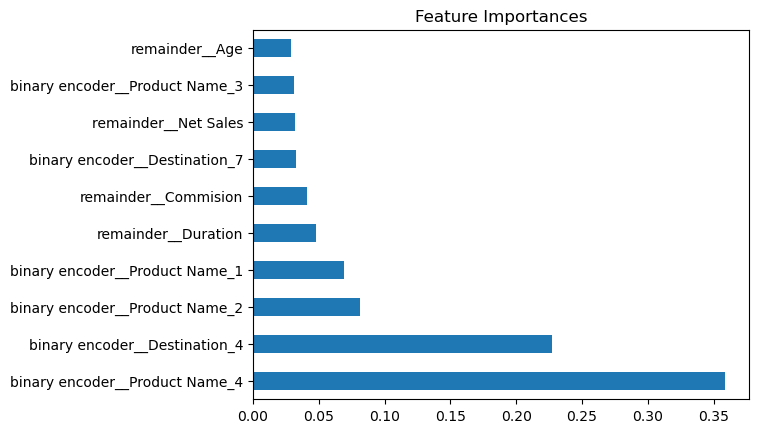

In [148]:
# Mendapatkan feature importances dari model XGBoost yang telah disesuaikan
coef1 = pd.Series(xgb_tuning['model'].feature_importances_, transformer.get_feature_names_out()).sort_values(ascending=False).head(10)

# Membuat plot bar horizontal untuk menampilkan feature importances
coef1.plot(kind='barh', title='Feature Importances')

# Menampilkan plot
plt.show()


Berdasarkan visualisasi diatas, ada beberapa fitur yang berpengaruh dalam menentukan pengguna yang melakukan claim dan tidak. fitur-fiturnya adalah berikut ini.
- `Product Name` atau nama produk asuransi
- `Destination` destinasi dari perjalanan

### Perbandingan hasil sebelum Tuning dan sesudah Tuning

In [149]:
# Mencetak skor recall dari model benchmark pada data uji
print('Recall Score model benchmark pada set data uji:', recall_score(y_test, y_pred))

# Mencetak skor recall setelah penyetelan model pada data uji
print('Recall Score setelah penyetelan model pada set data uji:', recall_score_xgb_tuning)


Recall Score model benchmark pada set data uji: 0.8962962962962963
Recall Score setelah penyetelan model pada set data uji: 0.8888888888888888


Dari analisis yang telah dilakukan, terlihat bahwa model XGB Classifier memiliki Recall score yang sama sebelum dan setelah dilakukan hyperparameter tuning. Oleh karena itu, kami akan menggunakan model XGB Classifier yang telah disesuaikan sebagai model akhir. Selanjutnya, mari kita tinjau laporan klasifikasi dari XGB Classifier setelah penyetelan hiperparameter.

In [150]:
print(classification_report(y_test, y_pred_xgb_tuning))

              precision    recall  f1-score   support

           0       0.98      0.09      0.16      7798
           1       0.02      0.89      0.03       135

    accuracy                           0.10      7933
   macro avg       0.50      0.49      0.09      7933
weighted avg       0.96      0.10      0.15      7933



## Kesimpulan

Berdasarkan hasil laporan klasifikasi model kita, kita dapat melihat bahwa model memiliki presisi yang tinggi untuk kelas negatif namun recall yang rendah, yang berarti model jarang memprediksi negatif tetapi ketika melakukannya, prediksinya akurat. Untuk kelas positif, presisinya rendah tetapi recallnya tinggi, menunjukkan bahwa model memprediksi kebanyakan kasus positif dengan benar tetapi dengan banyak kesalahan positif.

Tanpa Model:
Jika kita asumsikan biaya pemasaran per pelanggan untuk semua pelanggan adalah $10.

Total Biaya: $10 × 7933 (berdasarkan angka support) = $79,330
Biaya yang Terbuang: $79,330
Dengan Model:

Jumlah True Positives: 0.90 × 135 = 121.5 = 122

Jumlah False Negatives: 135 - 122 = 13

Jumlah True Negatives: 0.98 × 7798 = 7642.04 = 7642

Jumlah False Positives: 7798 − 7642 = 156


Asumsi:

Biaya kesalahan False Negatives: Model memprediksi pelanggan tidak akan klaim, tetapi sebenarnya akan klaim (kehilangan nilai seumur hidup) = $1,000

Biaya kesalahan False Positives: Model memprediksi pelanggan akan klaim, tetapi sebenarnya tidak akan klaim (biaya pemasaran dan biaya staf) = $100

Manfaat setiap True Positives: Model dengan benar memprediksi pelanggan yang akan klaim (marginal profit, loyalitas pelanggan, pengurangan biaya operasional) = $500


Total biaya FN = $1,000 × 13 = $13,000

Total biaya FP = $100 × 156 = $15,600

Total biaya dengan model = $13,000 + $15,600 = $28,600

Total manfaat TP = $500 × 122 = $61,000

Total biaya menggunakan model = $61,000 - $28,600 = $32,400

Persentase penghematan antara tanpa model dan dengan model adalah "$79,330 - $32,400 = $46,930," yang merupakan sekitar 59.20% dari biaya awal.

Dengan menggunakan model, perusahaan dapat menghemat $46,930 dibandingkan dengan menggunakan metode tanpa model, dengan peningkatan keuntungan perusahaan sebesar 59.20%. Pemanfaatan model ini dapat memiliki dampak positif pada pengambilan keputusan strategis, seperti alokasi sumber daya dan peningkatan produk atau layanan.

## Rekomendasi

### Rekomendasi Untuk Model

Hal-hal yang dapat dilakukan untuk mengembangkan proyek dan model lebih lanjut:

1. **Mengembangkan Kebijakan Pengisian Informasi**: Mendorong pelanggan untuk mengisi informasi seperti `Gender` dapat meningkatkan kualitas data dan kemampuan model untuk membuat prediksi yang lebih akurat.

2. **Penambahan Fitur**: Menambahkan kolom seperti 'Jenis Perjalanan' (bisnis, liburan, dll.), 'Jumlah Penumpang' (misalnya, apakah asuransi ini untuk perorangan atau keluarga), dan 'Riwayat Klaim' (berapa kali pelanggan ini mengajukan klaim sebelumnya) dapat meningkatkan kekayaan informasi dan kemampuan model untuk memahami pola-pola yang lebih kompleks dalam data.

3. **Eksplorasi Algoritma dan Tuning Hyperparameter**: Menggunakan algoritma machine learning yang berbeda dan melakukan tuning hyperparameter kembali dapat membantu meningkatkan kinerja model. Selain itu, mencoba teknik oversampling yang berbeda seperti SMOTETomek atau SMOTEENN juga bisa menjadi strategi yang berguna.

4. **Analisis Data yang Salah Tebak**: Menganalisis data yang model masih salah tebak dapat memberikan wawasan berharga tentang alasan di balik prediksi yang tidak akurat. Ini dapat membantu dalam mengidentifikasi pola-pola yang tidak terdeteksi atau fitur-fitur yang mungkin perlu diperbaiki.

5. **Penambahan Fitur Tambahan**: Menambahkan fitur seperti `Jenis Perjalanan` dapat membantu perusahaan dalam menyesuaikan jenis asuransi yang ditawarkan. Fitur-fitur tambahan ini dapat membantu dalam pengembangan paket asuransi yang lebih disesuaikan dengan kebutuhan pelanggan.

6. **Penggunaan Fitur `Jumlah Penumpang` dan `Riwayat Klaim`**: Dengan mempertimbangkan fitur-fitur ini, perusahaan dapat mengembangkan program loyalitas atau diskon untuk pelanggan yang sering bepergian tanpa klaim. Ini dapat meningkatkan retensi pelanggan dan menciptakan hubungan jangka panjang yang lebih kuat.

Dengan menggabungkan langkah-langkah ini, proyek dan model dapat ditingkatkan untuk memberikan nilai tambah yang lebih besar bagi perusahaan dan pelanggan.

### Rekomendasi Untuk Business

Berdasarkan feature importances dari model XGB Classifier yang digunakan, fitur `Product Name` menjadi fitur paling penting, diikuti oleh `Destination`.

Dengan informasi ini, perusahaan dapat lebih fokus pada fitur-fitur tersebut saat memprediksi apakah pemilik polis asuransi perjalanan akan melakukan klaim atau tidak. Analisis lebih lanjut pada fitur `Product Name` dan `Destination` dapat memberikan wawasan yang lebih dalam tentang perilaku klaim asuransi pelanggan. Semakin signifikan kontribusi fitur-fitur ini terhadap prediksi klaim, semakin besar juga potensi untuk mengoptimalkan strategi manajemen risiko dan penawaran produk.

## Saving Model

In [151]:
import pickle

In [152]:
with open('xgb_model.pkl', 'wb') as file_model:
    pickle.dump(xgb_tuning, file_model)